# Packages Installation

In [1]:
# Pakcage Library
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from transformers import CLIPProcessor, CLIPModel
import torch
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE

# Original Data + PCA

In [2]:
output = pd.read_csv('/content/sample_data/output.csv')

In [3]:
output.head()

text  standard_stars_x  \
0  If you decide to eat here, just be aware it is...              0.00   
1  Family diner. Had the buffet. Eclectic assortm...              0.25   
2  Wow!  Yummy, different,  delicious.   Our favo...              0.50   
3  Cute interior and owner (?) gave us tour of up...              0.50   
4  I am a long term frequent customer of this est...              0.50   

   standard_stars_y  subjectivity  roberta_polarity  absolute_diff  \
0               0.0      0.412121          0.656539       0.656539   
1               0.0      0.522294          0.961204       0.961204   
2               1.0      0.733838          0.984615       0.015385   
3               0.5      0.490260          0.980289       0.480289   
4              -1.0      0.405556         -0.901215       0.098785   

   word_count  FCU_count  absolute_diff_x_p  
0          42        0.0           0.656539  
1          37        0.0           0.711204  
2          23        2.0           0.484615  
3          60        2.0           0.480289  
4          34        4.0           1.401215

## PCA

In [4]:
# Standardization
ss = StandardScaler()
final_dataframe = output.drop(columns=['text','standard_stars_x','standard_stars_y','roberta_polarity']).copy()
final_dataframe
col = list(final_dataframe.columns)

for i in ['subjectivity',
 'absolute_diff',
 'word_count',
 'FCU_count',
 'absolute_diff_x_p']:
    final_dataframe[i] = ss.fit_transform(final_dataframe[[i]]) # Standardization

final_dataframe.head()

subjectivity  absolute_diff  word_count  FCU_count  absolute_diff_x_p
0     -1.252583       1.217792   -0.152997  -0.438616           0.310831
1     -0.418638       2.217123   -0.266684  -0.438616           0.477548
2      1.182624      -0.885254   -0.585006   0.242427          -0.213499
3     -0.661121       0.639675    0.256274   0.242427          -0.226694
4     -1.302281      -0.611694   -0.334896   0.923470           2.581931

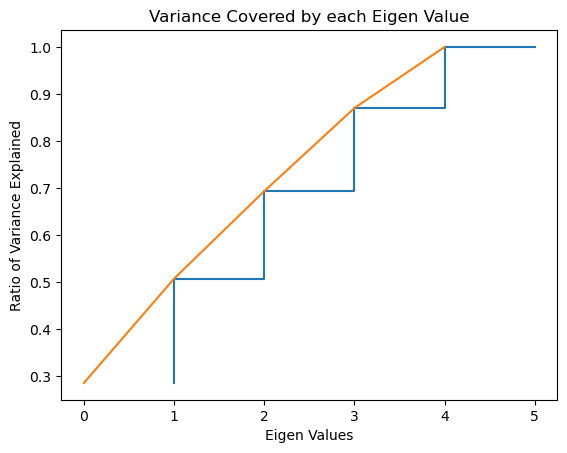

In [ ]:
# Dimensionality Reduction

pca = PCA()
pca.fit(final_dataframe)

plt.step(list(range(1,6)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()


In [ ]:
pca = PCA(n_components=0.85) # Retain 85% of the variance
PCA_arr = pca.fit_transform(final_dataframe)
PCA_arr

array([[ 0.41034829, -1.54160115, -0.86748164, -0.14115987],
       [ 0.23072823, -1.95803253, -0.6858025 ,  1.08190351],
       [-0.91223201,  1.10712289,  0.66892687,  0.24858494],
       ...,
       [-0.74646736,  1.2035674 , -0.45430967, -0.14499879],
       [ 0.40055035, -3.28794845, -1.42233706,  3.70282128],
       [-0.18818965,  0.47398493, -0.29987572, -0.74524917]])

In [ ]:
PCA_arr.shape

(10001, 4)

In [ ]:
pca_df = pd.DataFrame(PCA_arr)

## PCA-KMeans

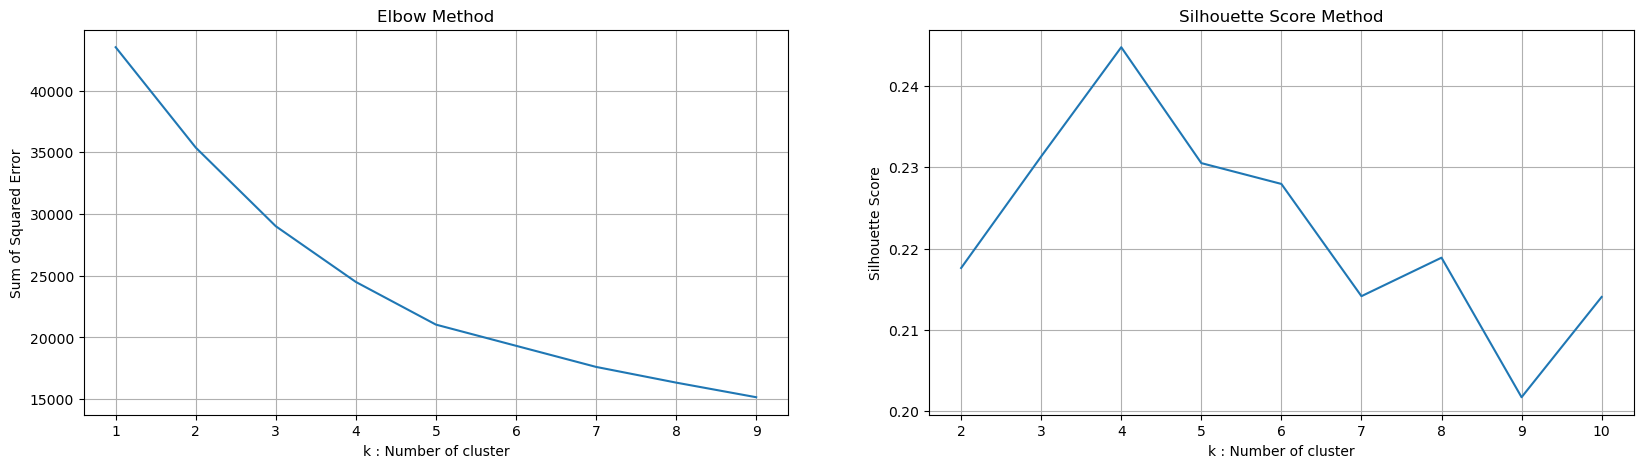

In [ ]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000).fit(PCA_arr)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(PCA_arr)
    labels = kmeans.labels_
    sil.append(silhouette_score(PCA_arr, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

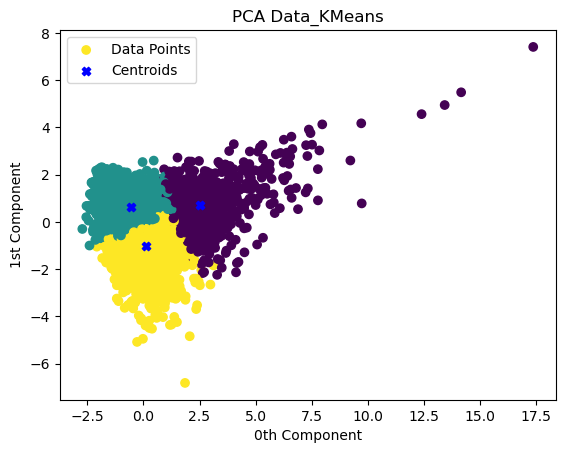

In [ ]:
model = KMeans(n_clusters = 3, max_iter = 10000).fit(PCA_arr)
centroids = np.array(model.cluster_centers_)
labels = model.labels_
pca_df['Class'] = labels

# For 2D plotting, use only the first two components
fig, ax = plt.subplots()  # Adjusted for 2D plotting
x = np.array(pca_df[0])
y = np.array(pca_df[1])
ax.scatter(x, y, c=pca_df['Class'], label='Data Points')
ax.scatter(centroids[:,0], centroids[:,1], marker="X", color='b', label='Centroids')
plt.title('PCA Data_KMeans')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')

plt.legend()
plt.show()

In [ ]:
# Evaluation
silhouette_avg_PCA_KMEANS = silhouette_score(pca_df.drop(columns = ['Class']), pca_df['Class'])
print(f'silhouette_score_PCA_KMEANS: {silhouette_avg_PCA_KMEANS}')
dbi_PCA_KMEANS = davies_bouldin_score(pca_df.drop(columns = ['Class']), pca_df['Class'])
print(f'Davies-Bouldin Index PCA_KEAMNS: {dbi_PCA_KMEANS}')

silhouette_score_PCA_KMEANS: 0.23084870769363092
Davies-Bouldin Index PCA_KEAMNS: 1.5308842557350033


## PCA-Hierarchical

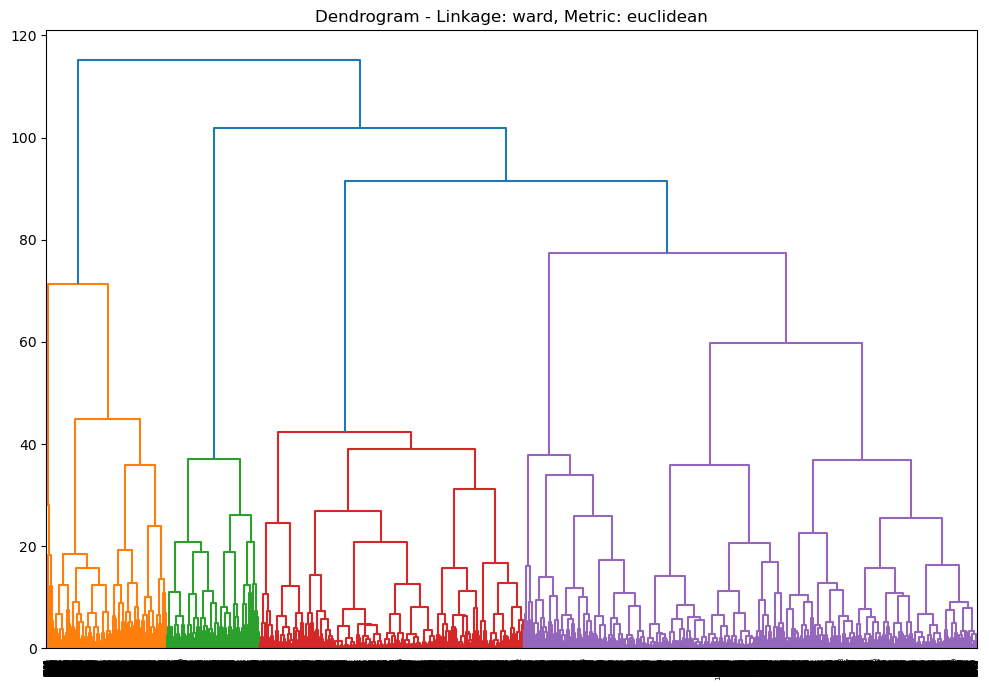

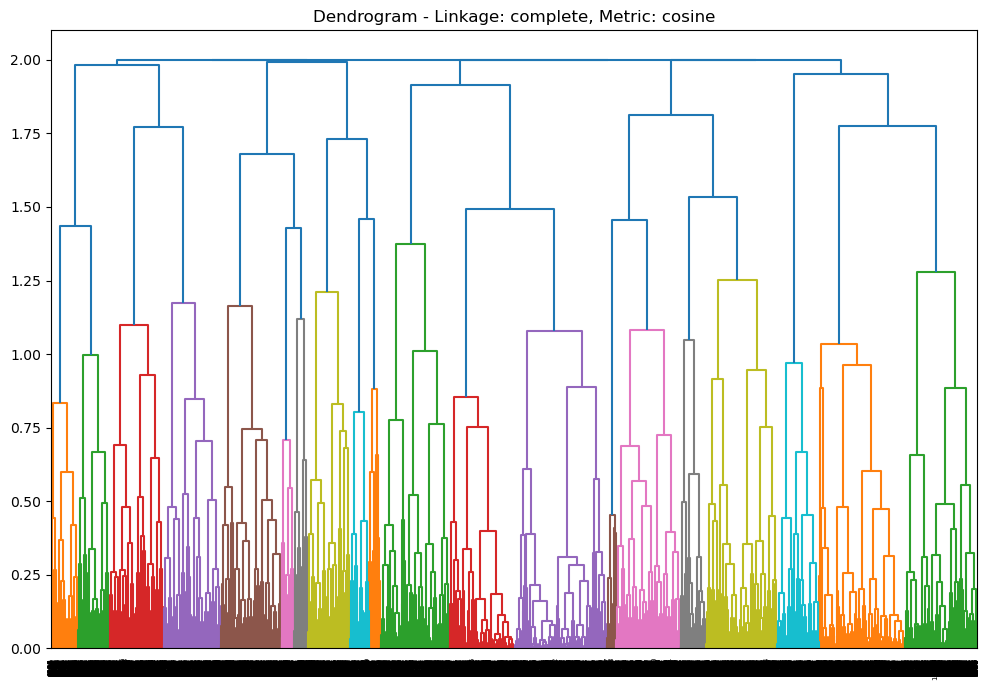

/var/folders/d5/v7l9v5kx5xqc637mjx5t_v_c0000gn/T/ipykernel_74444/3083929726.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_data = linkage(squareform(distance_matrix), method=linkage_method)


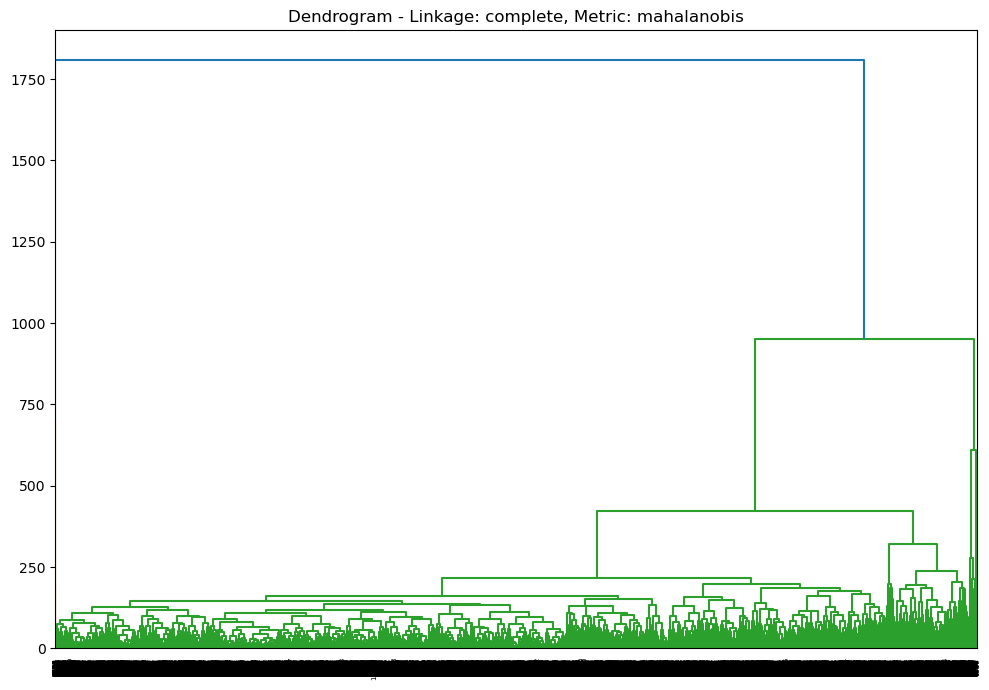

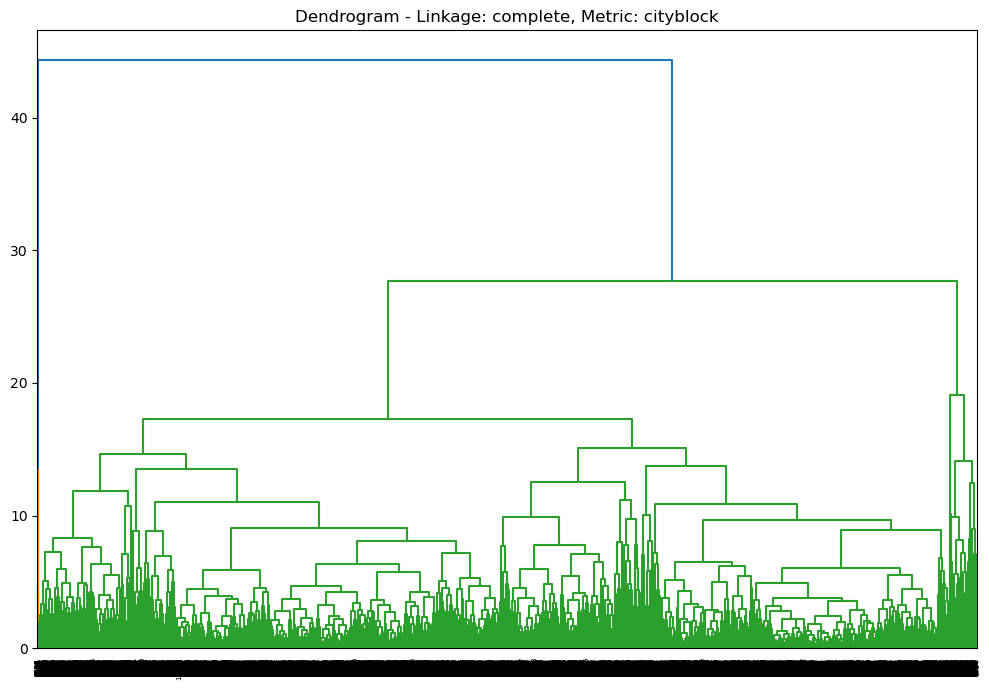

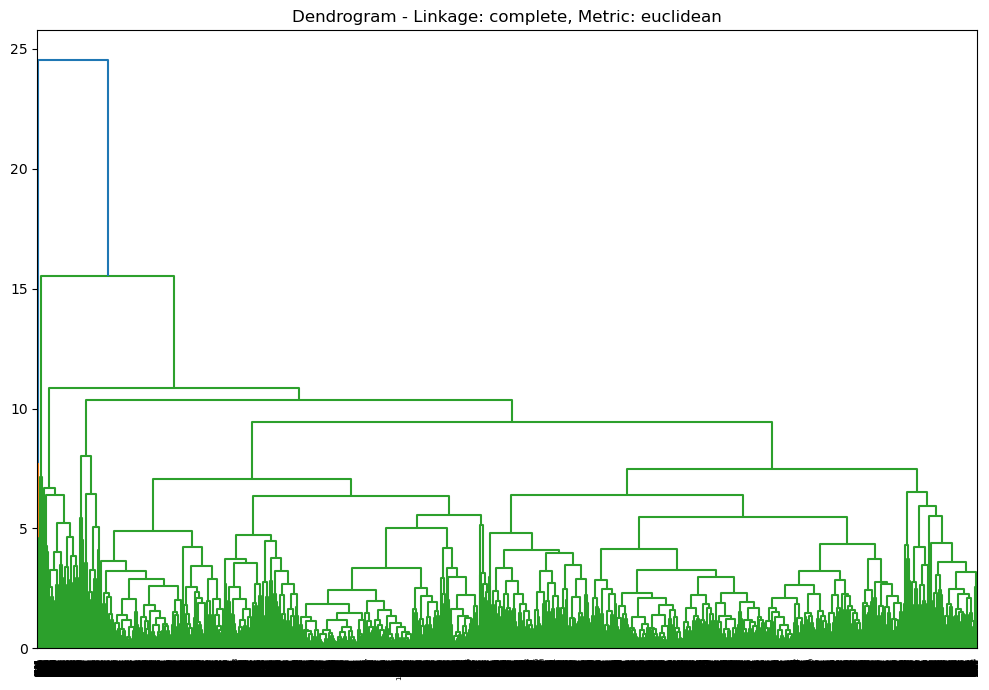

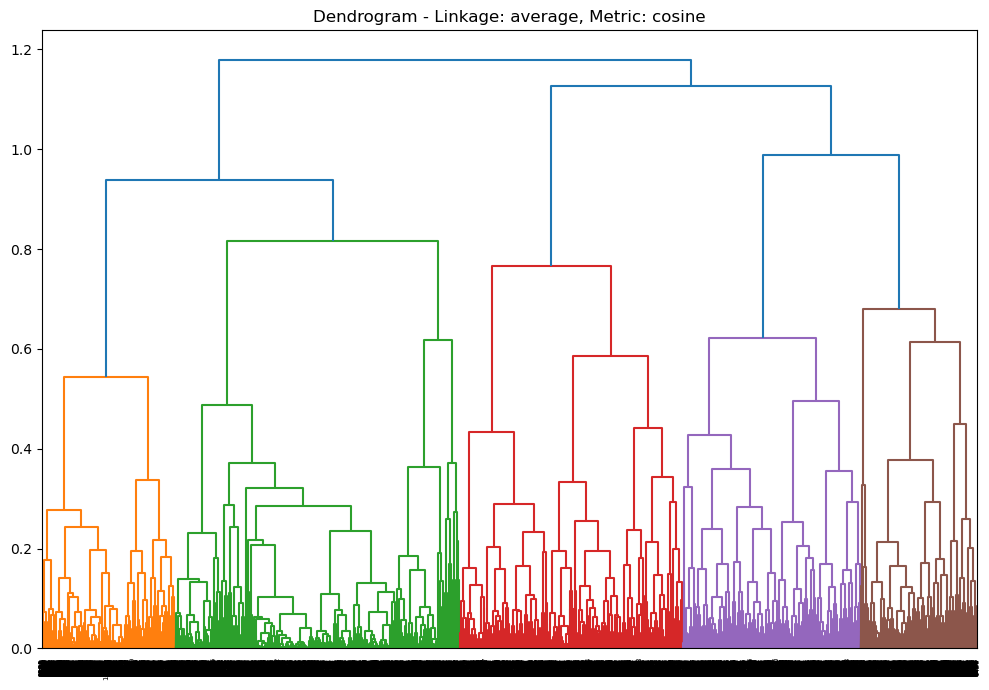

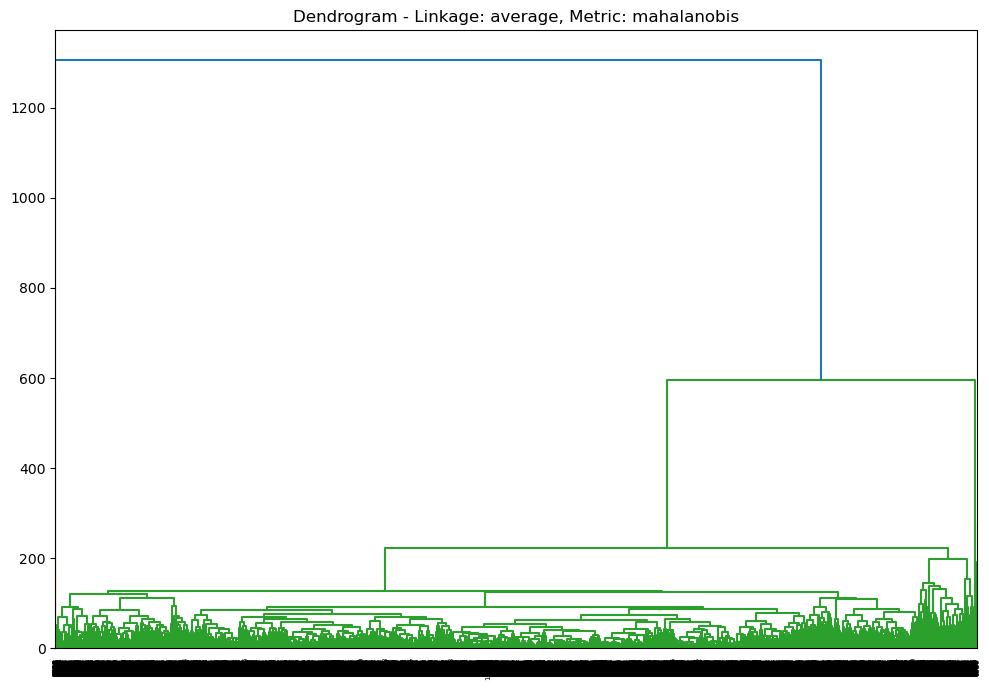

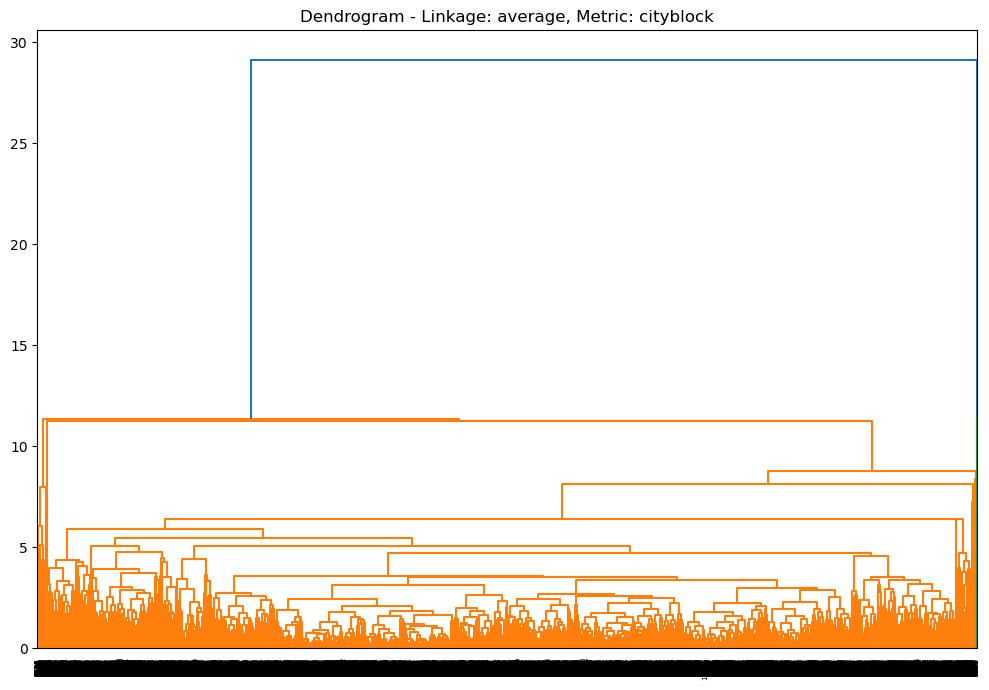

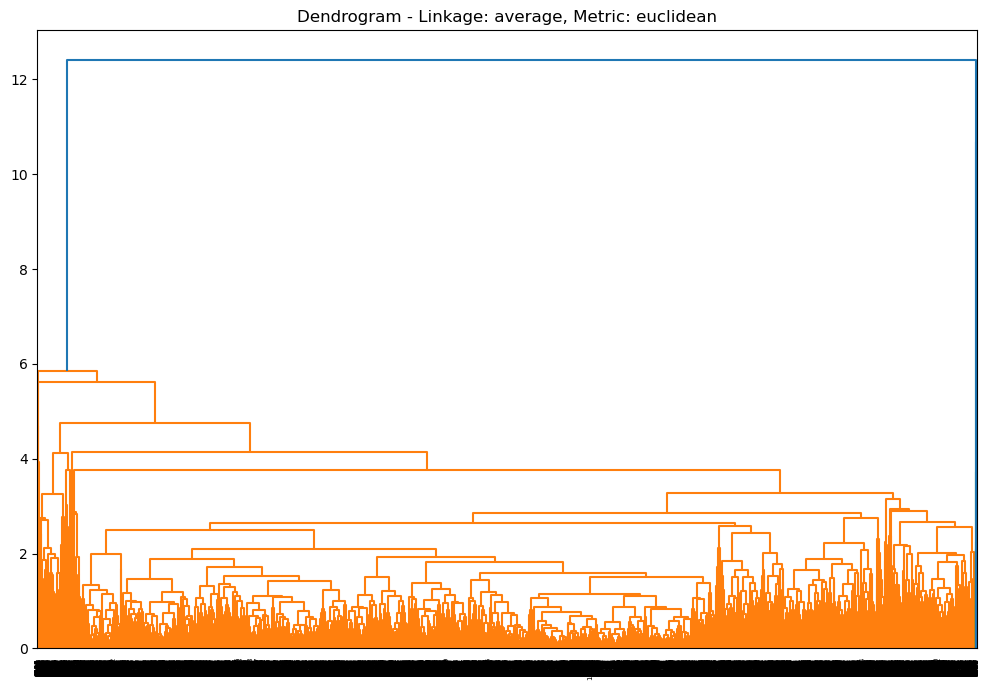

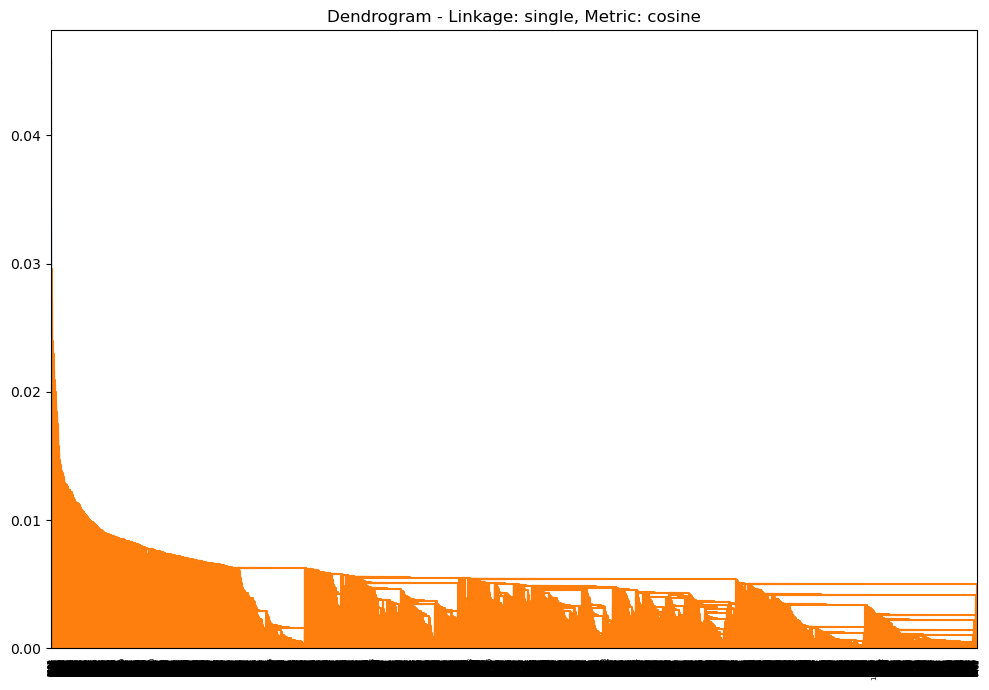

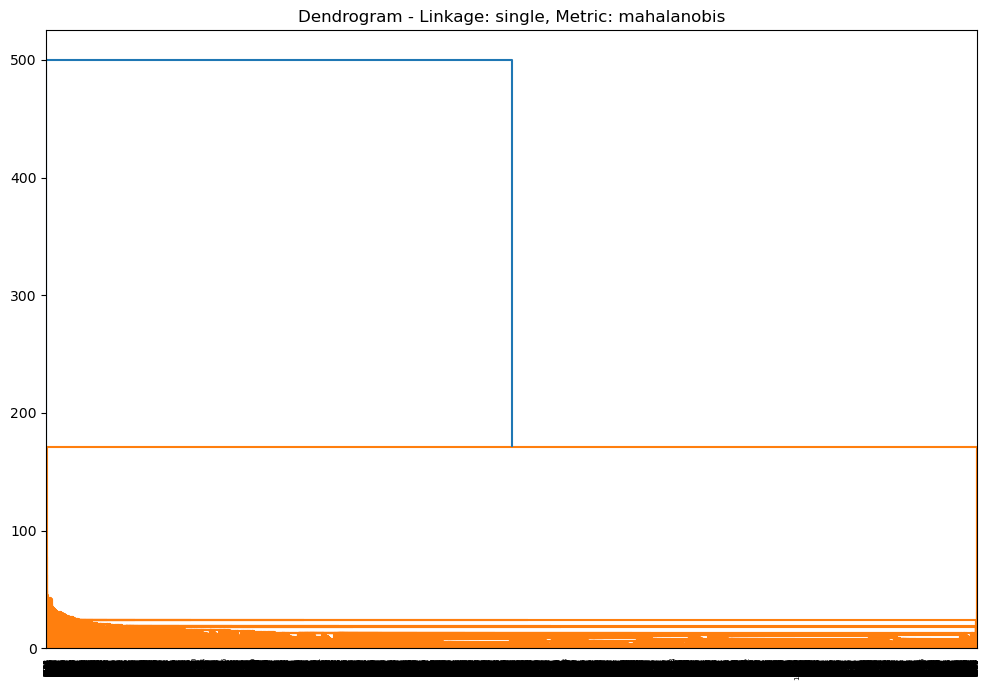

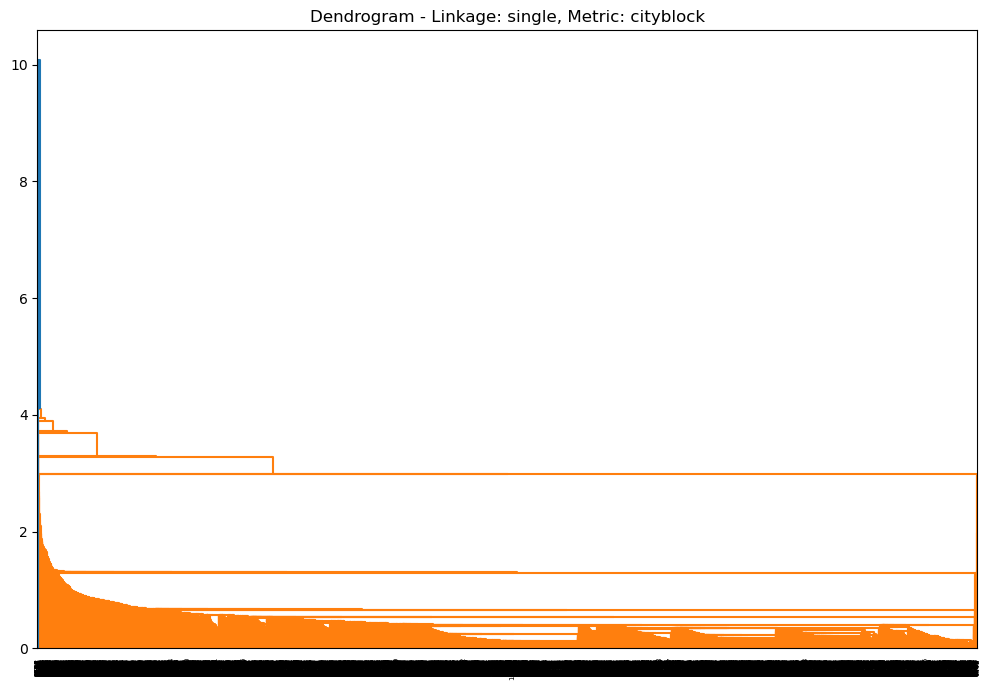

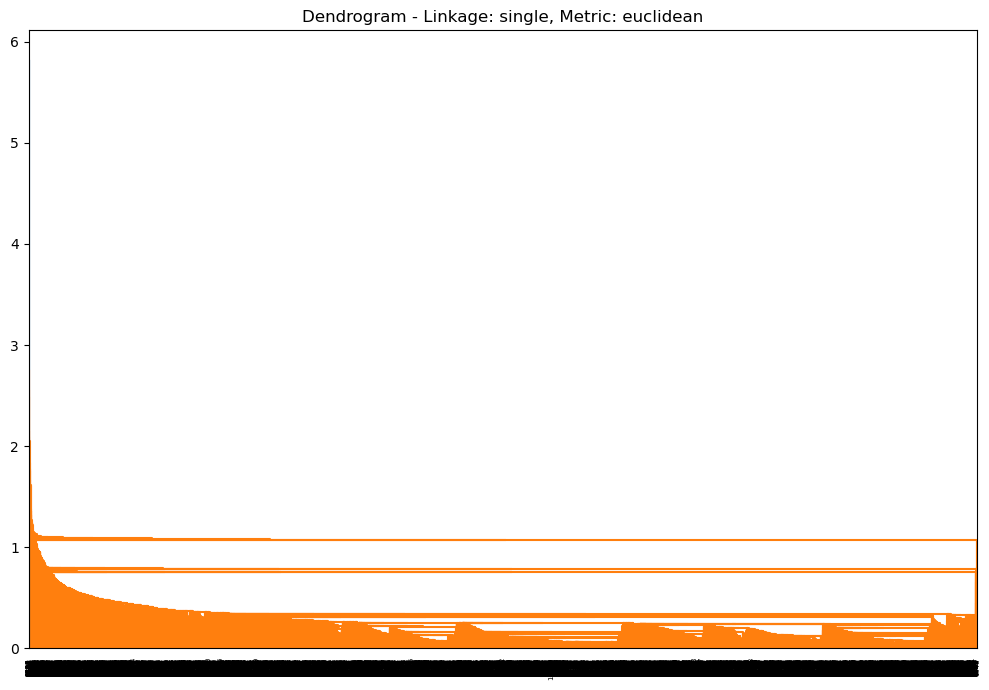

In [ ]:
# Use dendrogram to choose K
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

linkages = ['ward', 'complete', 'average', 'single']
metrics = ['cosine', 'mahalanobis', 'cityblock', 'euclidean']

for linkage_method in linkages:
    for metric in metrics:
        # Skip incompatible combinations
        if linkage_method == 'ward' and metric != 'euclidean':
            continue
        else:
            # Calculate linkage data
            # For 'mahalanobis', additional arguments are required
            if metric == 'mahalanobis':
                try:
                    # Using pdist to compute the distance matrix as mahalanobis requires VI to be invertible
                    # which might not be the case for all datasets
                    distance_matrix = pdist(PCA_arr, metric=metric, VI=np.linalg.inv(np.cov(PCA_arr, rowvar=False)))
                    linkage_data = linkage(squareform(distance_matrix), method=linkage_method)
                except np.linalg.LinAlgError:
                    print(f"Skipping mahalanobis for {linkage_method} due to non-invertible covariance matrix.")
                    continue
            else:
                linkage_data = linkage(PCA_arr, method=linkage_method, metric=metric)

            # Plot dendrogram
            plt.figure(figsize=(10, 7))
            dendrogram(linkage_data)
            plt.title(f'Dendrogram - Linkage: {linkage_method}, Metric: {metric}')
            plt.tight_layout()
            plt.show()


In [ ]:
# Choose K from dendrograms and run a model
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, linkage = 'complete',metric='euclidean')
labels = hierarchical_cluster.fit(PCA_arr)

pred_agc = pd.Series(hierarchical_cluster.labels_)
pca_df['Class_HC'] = pred_agc
output['Class_HC'] = pred_agc

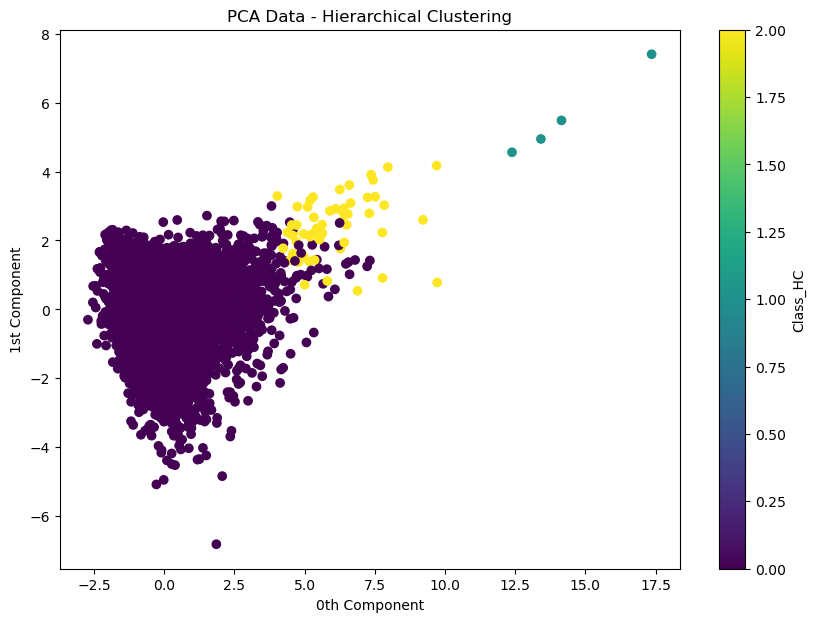

In [ ]:
# Plot a 2D graph
x = np.array(pca_df[0]) # 0th Component
y = np.array(pca_df[1]) # 1st Component

plt.figure(figsize=(10, 7))  # Optional: Adjusts the figure size
plt.scatter(x, y, c=pca_df['Class_HC'])  # Color points by hierarchical clustering label
plt.title('PCA Data - Hierarchical Clustering')  # Sets the title of the plot
plt.xlabel('0th Component')  # Sets the label for the x-axis
plt.ylabel('1st Component')  # Sets the label for the y-axis
plt.colorbar(label='Class_HC')  # Optional: Adds a colorbar to interpret cluster labels
plt.show()


In [ ]:
# Evaluation
silhouette_avg_PCA_Hier = silhouette_score(pca_df.drop(columns = ['Class','Class_HC']), pca_df['Class_HC'])
print(f'silhouette_score_PCA_Hier: {silhouette_avg_PCA_Hier}')
dbi_PCA_Hier = davies_bouldin_score(pca_df.drop(columns = ['Class','Class_HC']), pca_df['Class_HC'])
print(f'Davies-Bouldin Index PCA_Hier: {dbi_PCA_Hier}')

silhouette_score_PCA_Hier: 0.662360352537421
Davies-Bouldin Index PCA_Hier: 0.4987070102042927


# Original Data + CLIP + TSNE

## Data + CLIP

In [ ]:
# Load dataset
output2 = pd.read_csv('output.csv')
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def create_clip_embeddings(text):
    # Tokenize the text input for CLIP
    inputs = processor(text=[text], return_tensors="pt", padding="max_length", truncation=True).to(model.device)

    # Get only the text embeddings
    with torch.no_grad():
        text_embeddings = model.get_text_features(**inputs)

    # Flatten the text_embeddings tensor to a 1D array to store in the DataFrame
    return text_embeddings.cpu().numpy().flatten()


# Now, apply the function to each text entry in the DataFrame
output2['clip_embeddings'] = output2['text'].apply(lambda txt: create_clip_embeddings(txt))

/Users/johnnys/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
output2.head()

text  standard_stars_x  \
0  If you decide to eat here, just be aware it is...              0.00   
1  Family diner. Had the buffet. Eclectic assortm...              0.25   
2  Wow!  Yummy, different,  delicious.   Our favo...              0.50   
3  Cute interior and owner (?) gave us tour of up...              0.50   
4  I am a long term frequent customer of this est...              0.50   

   standard_stars_y  subjectivity  roberta_polarity  absolute_diff  \
0               0.0      0.412121          0.656539       0.656539   
1               0.0      0.522294          0.961204       0.961204   
2               1.0      0.733838          0.984615       0.015385   
3               0.5      0.490260          0.980289       0.480289   
4              -1.0      0.405556         -0.901215       0.098785   

   word_count  FCU_count  absolute_diff_x_p  \
0          42        0.0           0.656539   
1          37        0.0           0.711204   
2          23        2.0           0.484615   
3          60        2.0           0.480289   
4          34        4.0           1.401215   

                                     clip_embeddings  
0  [-0.07340146, -0.041122958, 0.012648124, -0.02...  
1  [0.18603128, 0.13566995, 0.047221705, 0.007334...  
2  [0.18768826, 0.07929449, -0.15932947, -0.14517...  
3  [0.05147922, 0.05215212, -0.12890027, -0.04015...  
4  [0.06401497, 0.07075465, 0.06773839, -0.242259...

In [ ]:
# We convert the embeddings from a list in a DataFrame column to a 2D numpy array
clip_array = np.stack(output2['clip_embeddings'].values)
clip_df = pd.DataFrame(output2['clip_embeddings'].apply(lambda x: x.flatten()).tolist(),
                             columns=[f'embed_{i}' for i in range(512)])
df_CLIP = pd.concat([output2.drop(columns=['clip_embeddings']), clip_df], axis=1)
df_CLIP

text  standard_stars_x  \
0      If you decide to eat here, just be aware it is...              0.00   
1      Family diner. Had the buffet. Eclectic assortm...              0.25   
2      Wow!  Yummy, different,  delicious.   Our favo...              0.50   
3      Cute interior and owner (?) gave us tour of up...              0.50   
4      I am a long term frequent customer of this est...              0.50   
...                                                  ...               ...   
9996   If you like pancakes and efficient no frill se...              0.50   
9997   Visited New Orleans for the end of Mardi Gras ...              0.50   
9998   This is one of my favorite little neighborhood...              0.75   
9999   The only good thing about this place is they k...              0.25   
10000  Pretty much the best Italian restaurant in the...              0.50   

       standard_stars_y  subjectivity  roberta_polarity  absolute_diff  \
0                   0.0      0.412121          0.656539       0.656539   
1                   0.0      0.522294          0.961204       0.961204   
2                   1.0      0.733838          0.984615       0.015385   
3                   0.5      0.490260          0.980289       0.480289   
4                  -1.0      0.405556         -0.901215       0.098785   
...                 ...           ...               ...            ...   
9996                1.0      0.450000          0.975761       0.024239   
9997                1.0      0.597340          0.990825       0.009175   
9998                1.0      0.641667          0.991449       0.008551   
9999               -1.0      0.630000          0.855644       1.855644   
10000               1.0      0.536979          0.963132       0.036868   

       word_count  FCU_count  absolute_diff_x_p   embed_0  ...  embed_502  \
0              42        0.0           0.656539 -0.073401  ...  -0.362730   
1              37        0.0           0.711204  0.186031  ...  -0.067391   
2              23        2.0           0.484615  0.187688  ...  -0.327219   
3              60        2.0           0.480289  0.051479  ...  -0.087999   
4              34        4.0           1.401215  0.064015  ...  -0.032732   
...           ...        ...                ...       ...  ...        ...   
9996           14        0.0           0.475761  0.115848  ...  -0.193195   
9997           70        1.0           0.490825  0.348834  ...  -0.225733   
9998           36        0.0           0.241449  0.338024  ...  -0.165583   
9999           19        0.0           0.605644 -0.001474  ...   0.253362   
10000          56        0.0           0.463132  0.177886  ...  -0.370661   

       embed_503  embed_504  embed_505  embed_506  embed_507  embed_508  \
0       0.451987   0.379295  -0.385848   0.307877  -0.092364   0.070684   
1       0.339695   0.298440  -0.138442   0.020813  -0.389179   0.199415   
2      -0.011071   0.127197   0.142973   0.236485  -0.317097   0.105248   
3      -0.036672   0.631617  -0.030687   0.188516  -0.339933   0.130326   
4       0.255896   0.282258  -0.385601   0.210853  -0.247832   0.032540   
...          ...        ...        ...        ...        ...        ...   
9996    0.229123   0.069728  -0.493906   0.119031  -0.248899   0.133107   
9997    0.340482   0.342589  -0.421637   0.287839  -0.232195   0.328696   
9998   -0.147008   0.520245  -0.272399   0.054688  -0.293158   0.282958   
9999    0.003901   0.384742  -0.190064   0.243205  -0.013834  -0.134781   
10000   0.325499   0.474304  -0.800947   0.272060  -0.318365   0.064482   

       embed_509  embed_510  embed_511  
0       0.099656   0.055344  -0.023722  
1       0.284068   0.302311   0.046828  
2      -0.659718  -0.255599  -0.422058  
3       0.009622   0.016542  -0.184318  
4       0.268785   0.432546  -0.055134  
...          ...        ...        ...  
9996   -1.019881   0.010494   0.097002  
9997    0.019024  -0.026156  -0.021598  
9998    0.057541   0.049313  -0

In [ ]:
final_dataframe_CLIP_original = df_CLIP.drop(columns=['text','standard_stars_x','standard_stars_y','roberta_polarity']).copy()
final_dataframe_CLIP_original


subjectivity  absolute_diff  word_count  FCU_count  absolute_diff_x_p  \
0          0.412121       0.656539          42        0.0           0.656539   
1          0.522294       0.961204          37        0.0           0.711204   
2          0.733838       0.015385          23        2.0           0.484615   
3          0.490260       0.480289          60        2.0           0.480289   
4          0.405556       0.098785          34        4.0           1.401215   
...             ...            ...         ...        ...                ...   
9996       0.450000       0.024239          14        0.0           0.475761   
9997       0.597340       0.009175          70        1.0           0.490825   
9998       0.641667       0.008551          36        0.0           0.241449   
9999       0.630000       1.855644          19        0.0           0.605644   
10000      0.536979       0.036868          56        0.0           0.463132   

        embed_0   embed_1   embed_2   embed_3   embed_4  ...  embed_502  \
0     -0.073401 -0.041123  0.012648 -0.020228  0.211520  ...  -0.362730   
1      0.186031  0.135670  0.047222  0.007335  0.065388  ...  -0.067391   
2      0.187688  0.079294 -0.159329 -0.145174 -0.027777  ...  -0.327219   
3      0.051479  0.052152 -0.128900 -0.040158  0.001955  ...  -0.087999   
4      0.064015  0.070755  0.067738 -0.242260  0.076531  ...  -0.032732   
...         ...       ...       ...       ...       ...  ...        ...   
9996   0.115848 -0.195240  0.141284 -0.089760  0.048322  ...  -0.193195   
9997   0.348834 -0.290700  0.071015 -0.019929  0.037133  ...  -0.225733   
9998   0.338024 -0.116429  0.003233  0.081458  0.163800  ...  -0.165583   
9999  -0.001474  0.170802 -0.043595 -0.210097  0.051745  ...   0.253362   
10000  0.177886 -0.310400  0.038181 -0.079144 -0.018631  ...  -0.370661   

       embed_503  embed_504  embed_505  embed_506  embed_507  embed_508  \
0       0.451987   0.379295  -0.385848   0.307877  -0.092364   0.070684   
1       0.339695   0.298440  -0.138442   0.020813  -0.389179   0.199415   
2      -0.011071   0.127197   0.142973   0.236485  -0.317097   0.105248   
3      -0.036672   0.631617  -0.030687   0.188516  -0.339933   0.130326   
4       0.255896   0.282258  -0.385601   0.210853  -0.247832   0.032540   
...          ...        ...        ...        ...        ...        ...   
9996    0.229123   0.069728  -0.493906   0.119031  -0.248899   0.133107   
9997    0.340482   0.342589  -0.421637   0.287839  -0.232195   0.328696   
9998   -0.147008   0.520245  -0.272399   0.054688  -0.293158   0.282958   
9999    0.003901   0.384742  -0.190064   0.243205  -0.013834  -0.134781   
10000   0.325499   0.474304  -0.800947   0.272060  -0.318365   0.064482   

       embed_509  embed_510  embed_511  
0       0.099656   0.055344  -0.023722  
1       0.284068   0.302311   0.046828  
2      -0.659718  -0.255599  -0.422058  
3       0.009622   0.016542  -0.184318  
4       0.268785   0.432546  -0.055134  
...          ...        ...        ...  
9996   -1.019881   0.010494   0.097002  
9997    0.019024  -0.026156  -0.021598  
9998    0.057541   0.049313  -0.209538  
9999   -1.421065   0.344409   0.093546  
10000   0.172686   0.159397  -0.165174  

[10001 rows x 517 columns]

In [ ]:
final_dataframe_CLIP = df_CLIP.drop(columns=['text','standard_stars_x','standard_stars_y','roberta_polarity']).copy()
final_dataframe_CLIP

col_clip = list(final_dataframe_CLIP.columns)
for i in col_clip:
    final_dataframe_CLIP[i] = ss.fit_transform(final_dataframe_CLIP[[i]]) # Standardization

final_dataframe_CLIP


subjectivity  absolute_diff  word_count  FCU_count  absolute_diff_x_p  \
0         -1.252583       1.217792   -0.152997  -0.438616           0.310831   
1         -0.418638       2.217123   -0.266684  -0.438616           0.477548   
2          1.182624      -0.885254   -0.585006   0.242427          -0.213499   
3         -0.661121       0.639675    0.256274   0.242427          -0.226694   
4         -1.302281      -0.611694   -0.334896   0.923470           2.581931   
...             ...            ...         ...        ...                ...   
9996      -0.965863      -0.856209   -0.789641  -0.438616          -0.240504   
9997       0.149413      -0.905622    0.483646  -0.098094          -0.194561   
9998       0.484939      -0.907669   -0.289421  -0.438616          -0.955103   
9999       0.396629       5.150970   -0.675955  -0.438616           0.155612   
10000     -0.307483      -0.814787    0.165324  -0.438616          -0.279019   

        embed_0   embed_1   embed_2   embed_3   embed_4  ...  embed_502  \
0     -0.574423 -0.254833 -0.374316  0.181952  0.935698  ...  -1.072937   
1      0.795745  0.823981 -0.180142  0.325444  0.196601  ...   0.579611   
2      0.804496  0.479970 -1.340186 -0.468536 -0.274599  ...  -0.874235   
3      0.085122  0.314344 -1.169288  0.078189 -0.124225  ...   0.464305   
4      0.151328  0.427859 -0.064915 -0.973975  0.252960  ...   0.773545   
...         ...       ...       ...       ...       ...  ...        ...   
9996   0.425080 -1.195273  0.348135 -0.180043  0.110287  ...  -0.124315   
9997   1.655572 -1.777785 -0.046515  0.183506  0.053696  ...  -0.306378   
9998   1.598479 -0.714358 -0.427191  0.711341  0.694343  ...   0.030188   
9999  -0.194547  1.038361 -0.690191 -0.806534  0.127599  ...   2.374368   
10000  0.752726 -1.897995 -0.230919 -0.124777 -0.228344  ...  -1.117311   

       embed_503  embed_504  embed_505  embed_506  embed_507  embed_508  \
0       1.424764   0.093896  -0.803528   0.487328   0.150796  -0.302566   
1       0.795556  -0.207234   0.370555  -0.929286  -1.499247   0.411336   
2      -1.169896  -0.844995   1.706035   0.135017  -1.098529  -0.110887   
3      -1.313349   1.033622   0.881917  -0.101701  -1.225480   0.028189   
4       0.326004  -0.267498  -0.802354   0.008531  -0.713476  -0.514100   
...          ...        ...        ...        ...        ...        ...   
9996    0.175984  -1.059028  -1.316327  -0.444593  -0.719409   0.043613   
9997    0.799967  -0.042807  -0.973370   0.388442  -0.626550   1.128291   
9998   -1.931596   0.618839  -0.265145  -0.762117  -0.965451   0.874640   
9999   -1.086005   0.114185   0.125582   0.168182   0.587355  -1.442015   
10000   0.716010   0.447742  -2.773416   0.310576  -1.105580  -0.336962   

       embed_509  embed_510  embed_511  
0       0.382790  -0.078584   0.267242  
1       0.768279   1.200365   0.634798  
2      -1.204588  -1.688841  -1.808031  
3       0.194584  -0.279523  -0.569442  
4       0.736332   1.874809   0.103590  
...          ...        ...        ...  
9996   -1.957462  -0.310847   0.896201  
9997    0.214239  -0.500644   0.278307  
9998    0.294754  -0.109814  -0.700830  
9999   -2.796087   1.418379   0.878192  
10000   0.535449   0.460270  -0.469704  

[10001 rows x 517 columns]

##  TSNE

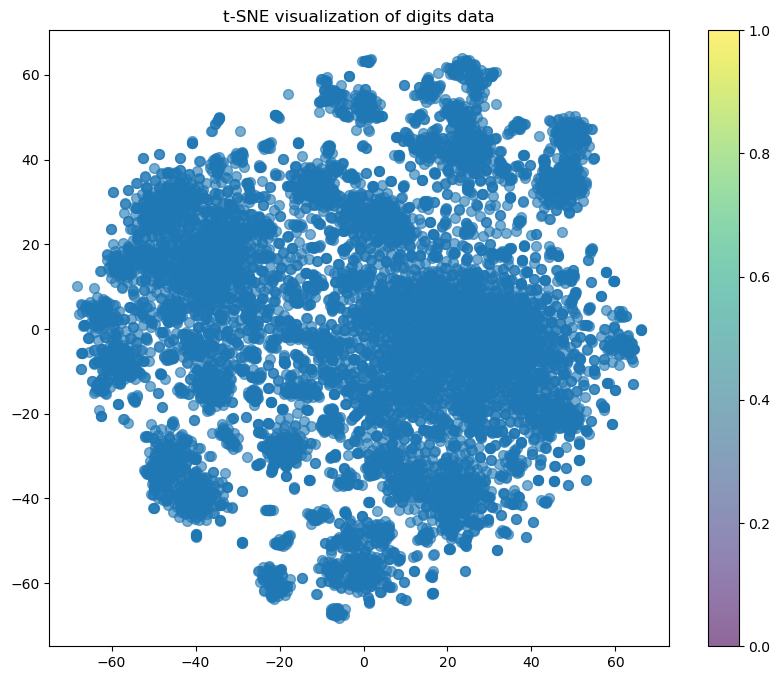

In [ ]:
# t-SNE Example
tsne = TSNE(n_components=2, random_state=42)

X_reduced = tsne.fit_transform(final_dataframe_CLIP)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
plt.title('t-SNE visualization of digits data')
plt.show()

### Fine-tune TSNE hyperparameter

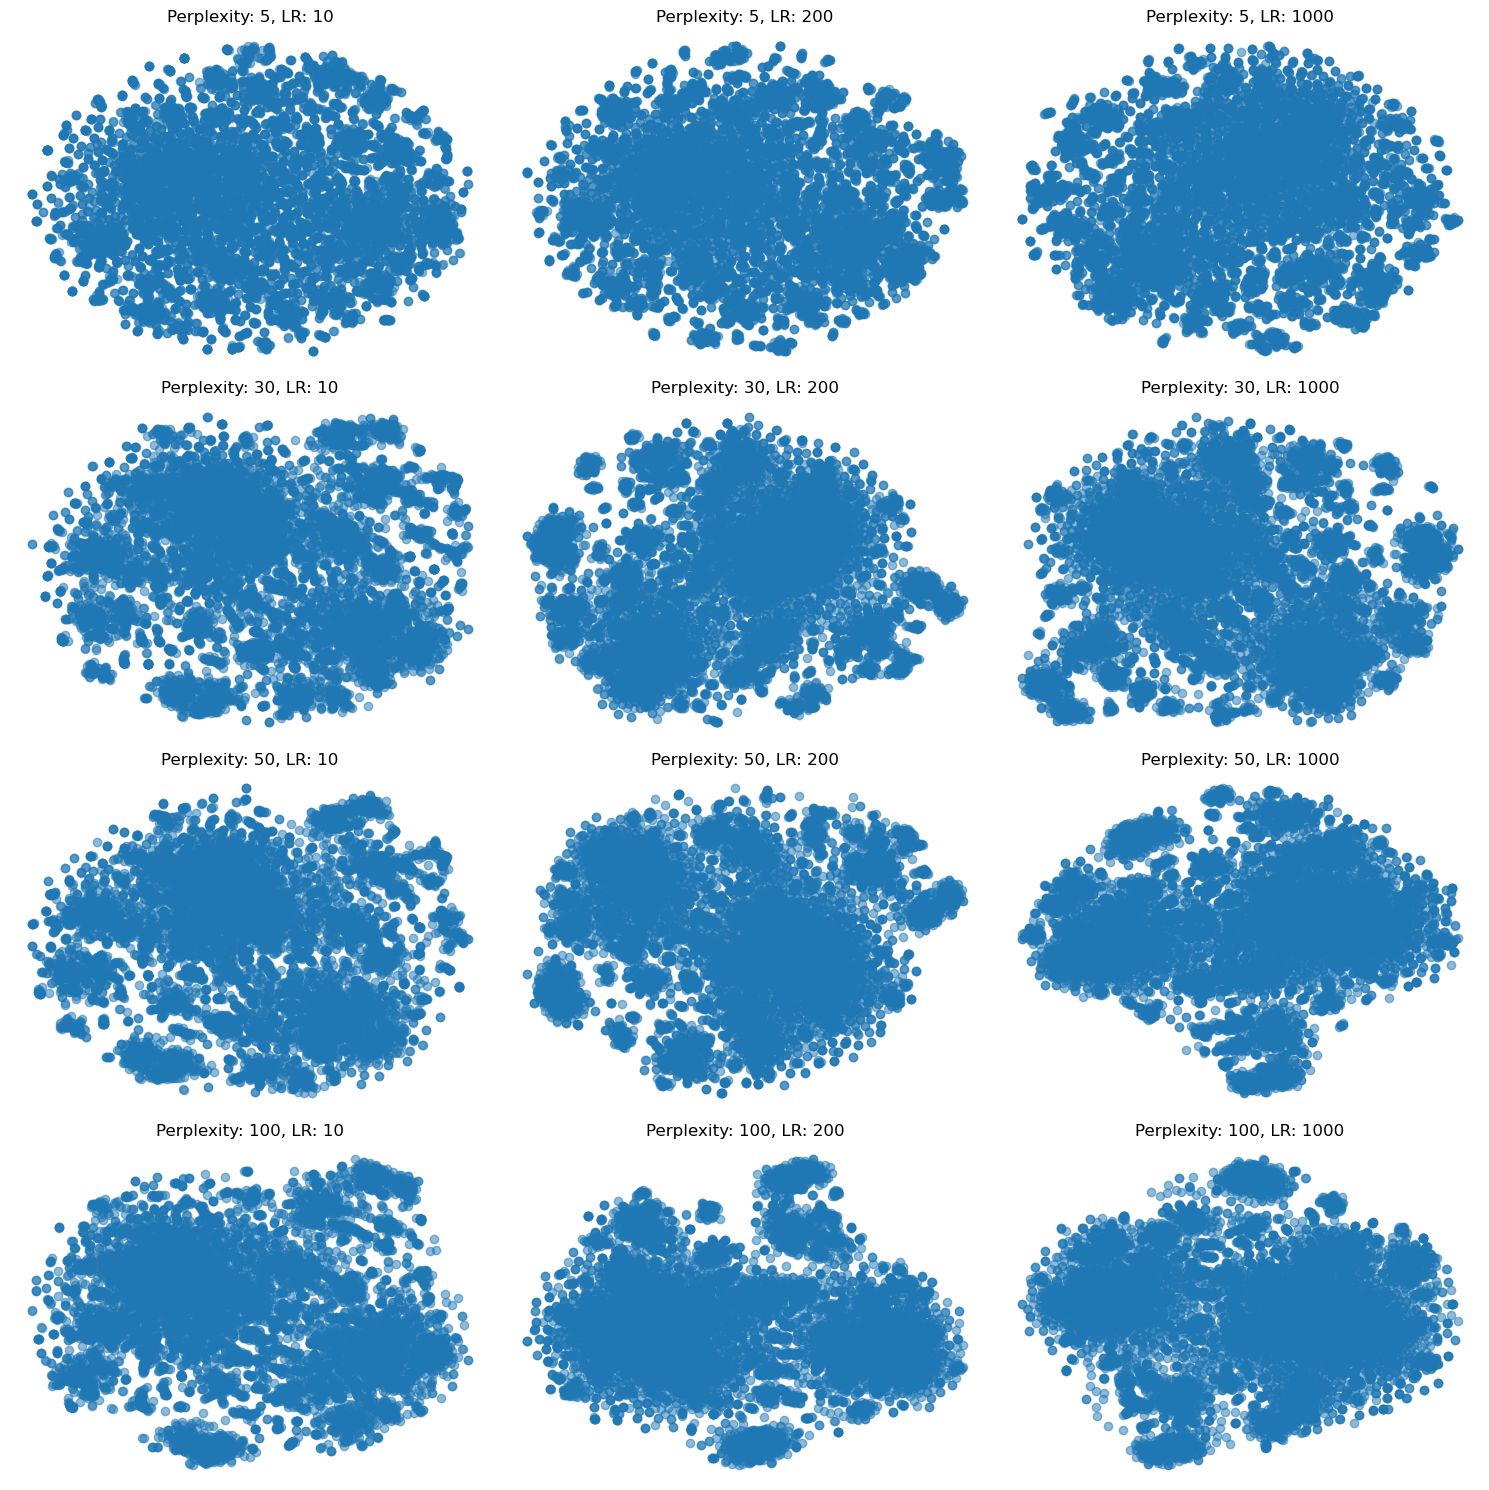

In [ ]:
# Setting up the hyperparameters to test
perplexities = [5, 30, 50, 100]
learning_rates = [10, 200, 1000]

# Creating subplots
fig, axs = plt.subplots(len(perplexities), len(learning_rates), figsize=(15, 15))

for i, perplexity in enumerate(perplexities):
    for j, learning_rate in enumerate(learning_rates):
        # Configuring t-SNE with different hyperparameters
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate,n_iter=1000)
        X_reduced = tsne.fit_transform(final_dataframe_CLIP)

        # Plotting
        axs[i, j].scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
        axs[i, j].set_title(f'Perplexity: {perplexity}, LR: {learning_rate}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

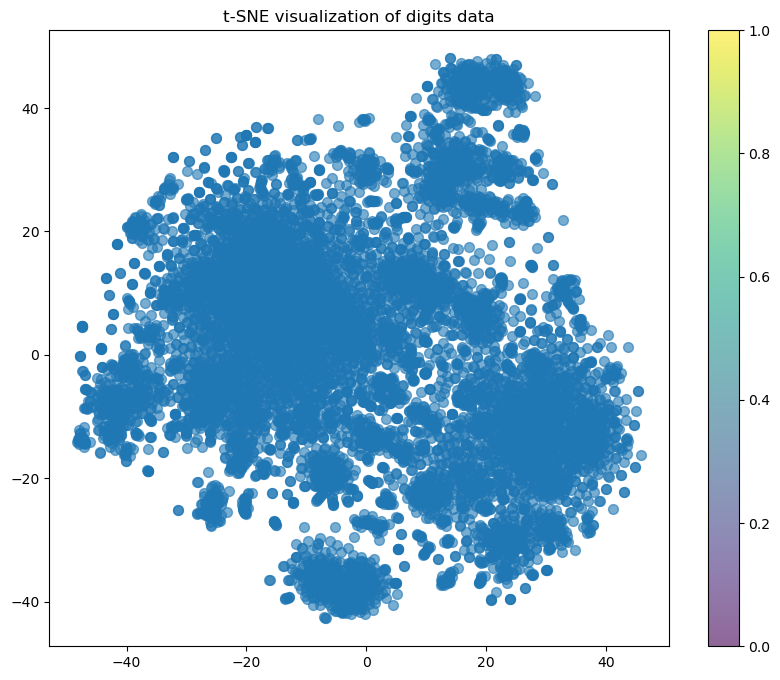

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=100, learning_rate=10, n_iter=10000)

df_tsne = tsne.fit_transform(final_dataframe_CLIP)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
plt.title('t-SNE visualization of digits data')
plt.show()

## TSNE + KMeans

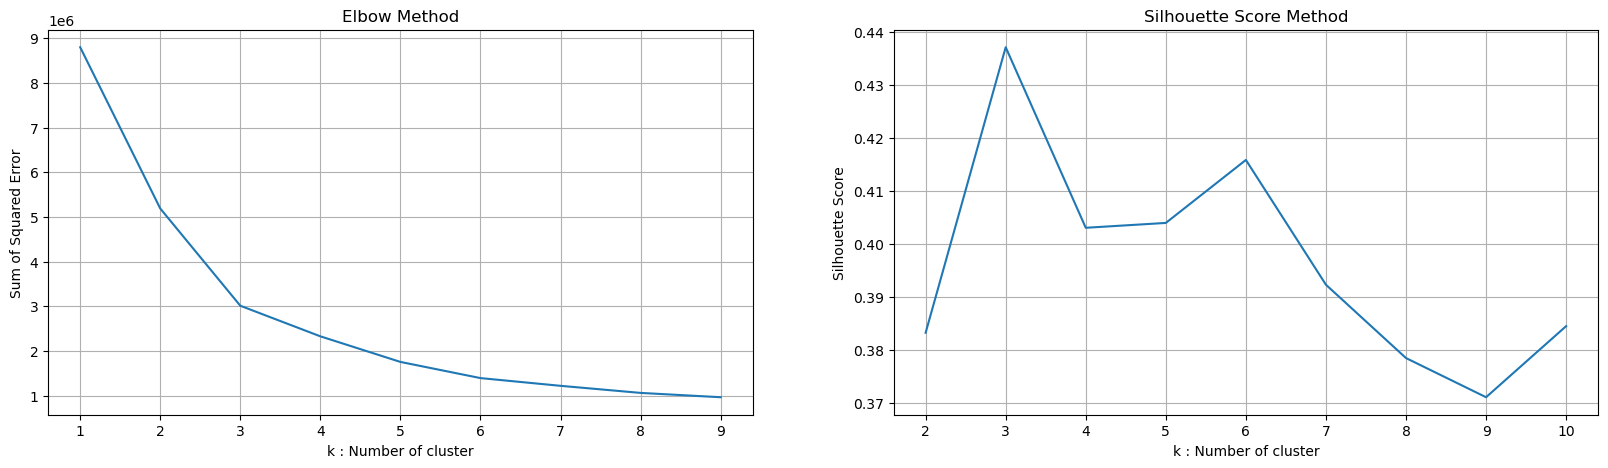

In [ ]:
# Choose K
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000).fit(df_tsne)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df_tsne)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_tsne, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [ ]:
dataframe_tsne = pd.DataFrame(df_tsne)

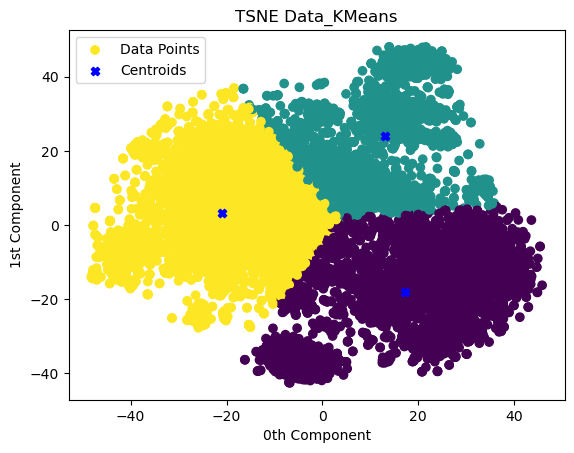

In [ ]:
model = KMeans(n_clusters = 3, max_iter = 10000).fit(df_tsne)
centroids = np.array(model.cluster_centers_)
labels = model.labels_
dataframe_tsne['Class'] = labels
final_dataframe_CLIP_original['Class'] = labels

# For 2D plotting, use only the first two components
fig, ax = plt.subplots()  # Adjusted for 2D plotting
x = np.array(dataframe_tsne[0])
y = np.array(dataframe_tsne[1])
ax.scatter(x, y, c=dataframe_tsne['Class'], label='Data Points')
ax.scatter(centroids[:,0], centroids[:,1], marker="X", color='b', label='Centroids')
plt.title('TSNE Data_KMeans')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')

plt.legend()
plt.show()

In [ ]:
# Evaluation
silhouette_avg_TSNE_KMEANS_clip = silhouette_score(dataframe_tsne.drop(columns = ['Class']), dataframe_tsne['Class'])
print(f'silhouette_score_TSNE_KMEANS_CLIP: {silhouette_avg_TSNE_KMEANS_clip}')
dbi_TSNE_KMEANS_clip = davies_bouldin_score(dataframe_tsne.drop(columns = ['Class']), dataframe_tsne['Class'])
print(f'Davies-Bouldin Index TSNE_KEAMNS_CLIP: {dbi_TSNE_KMEANS_clip}')

silhouette_score_TSNE_KMEANS_CLIP: 0.4375605285167694
Davies-Bouldin Index TSNE_KEAMNS_CLIP: 0.7639196816156874


## TSNE + Hier

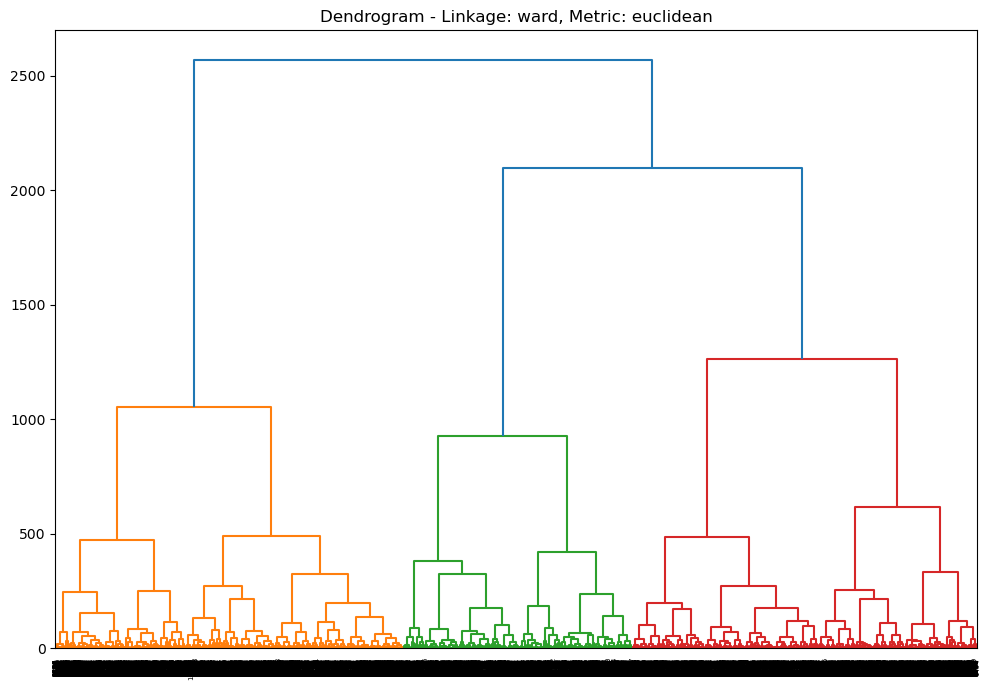

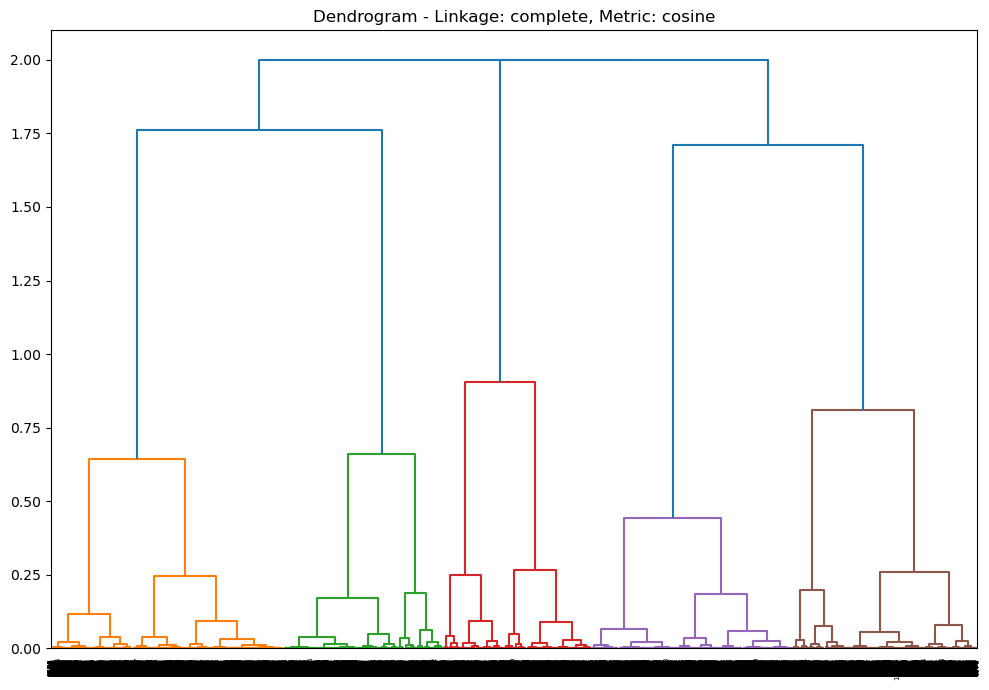

/var/folders/d5/v7l9v5kx5xqc637mjx5t_v_c0000gn/T/ipykernel_74444/3329412889.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_data = linkage(squareform(distance_matrix), method=linkage_method)


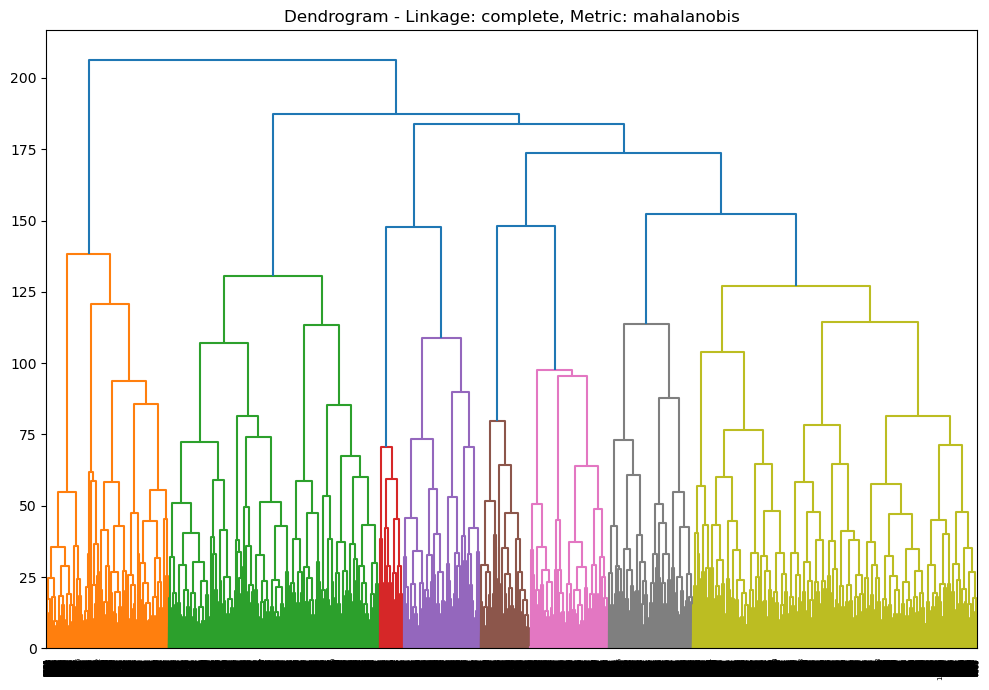

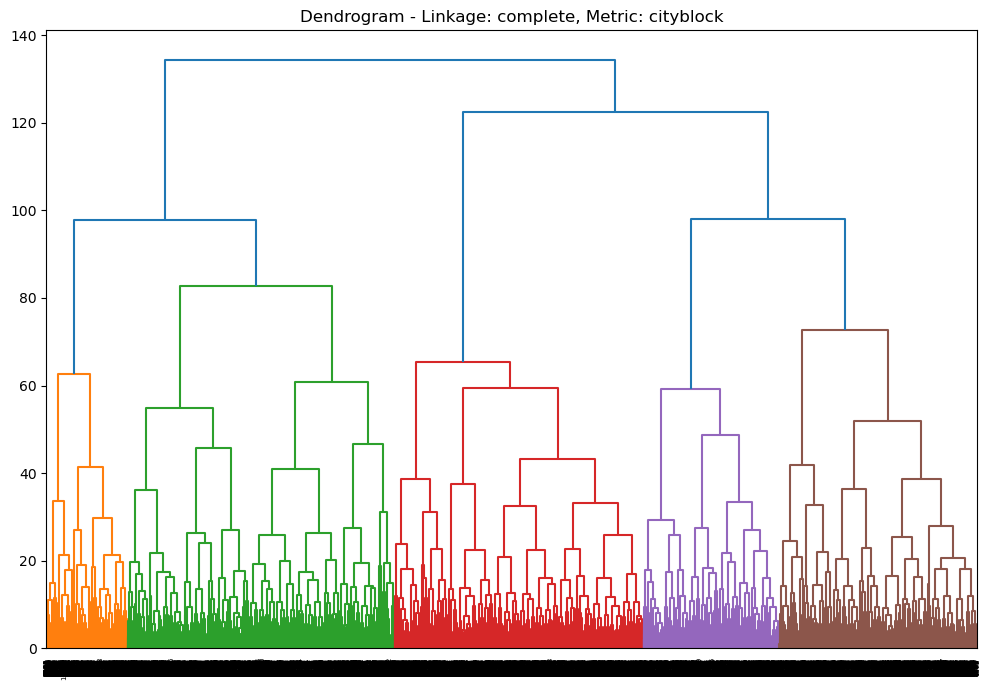

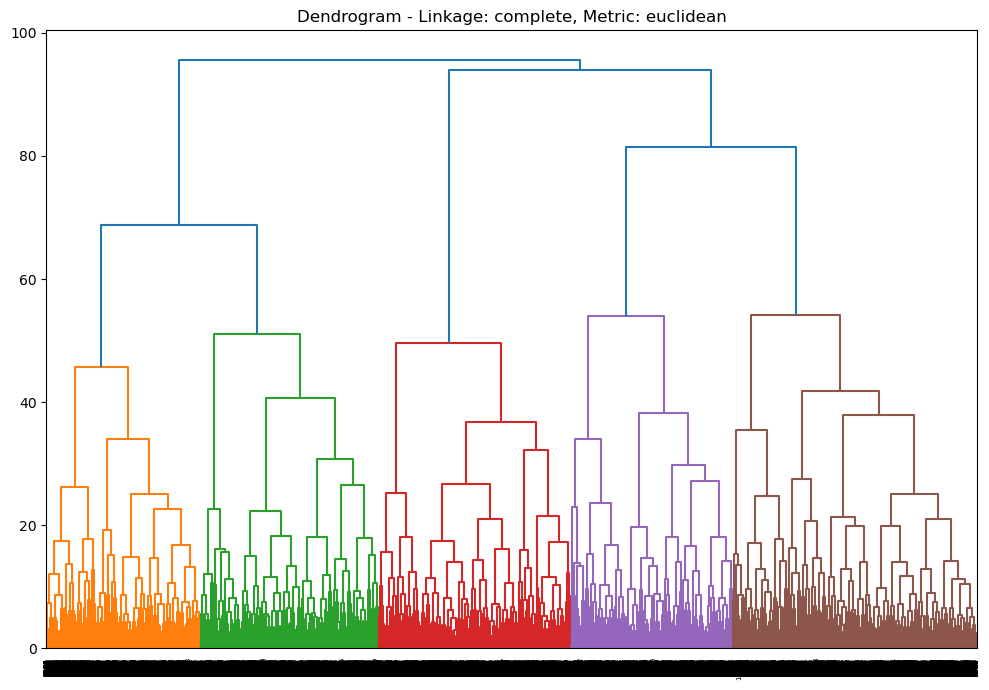

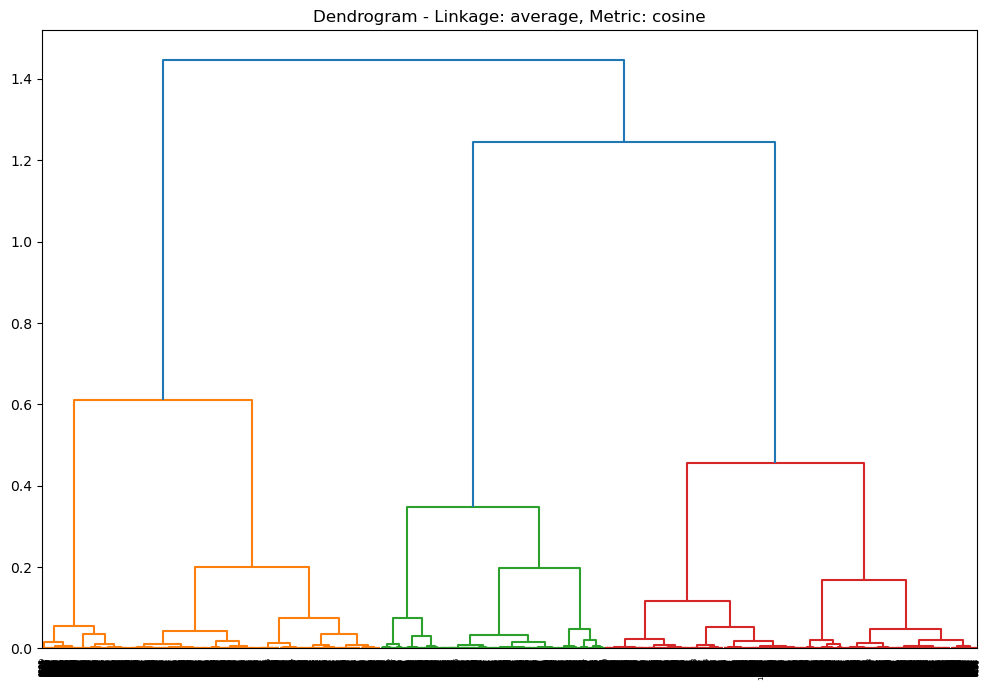

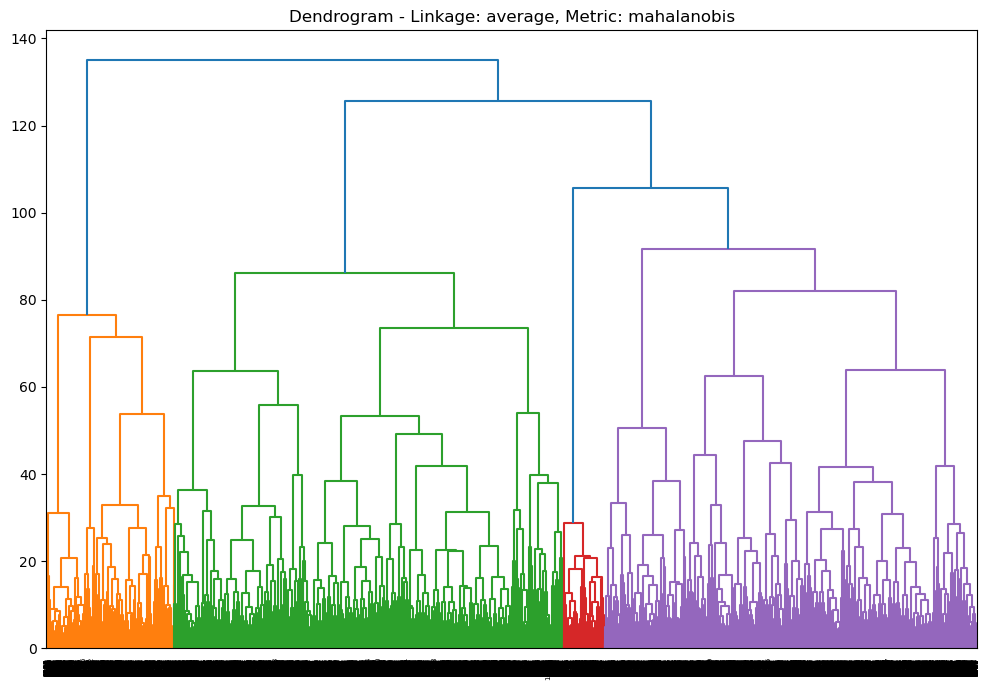

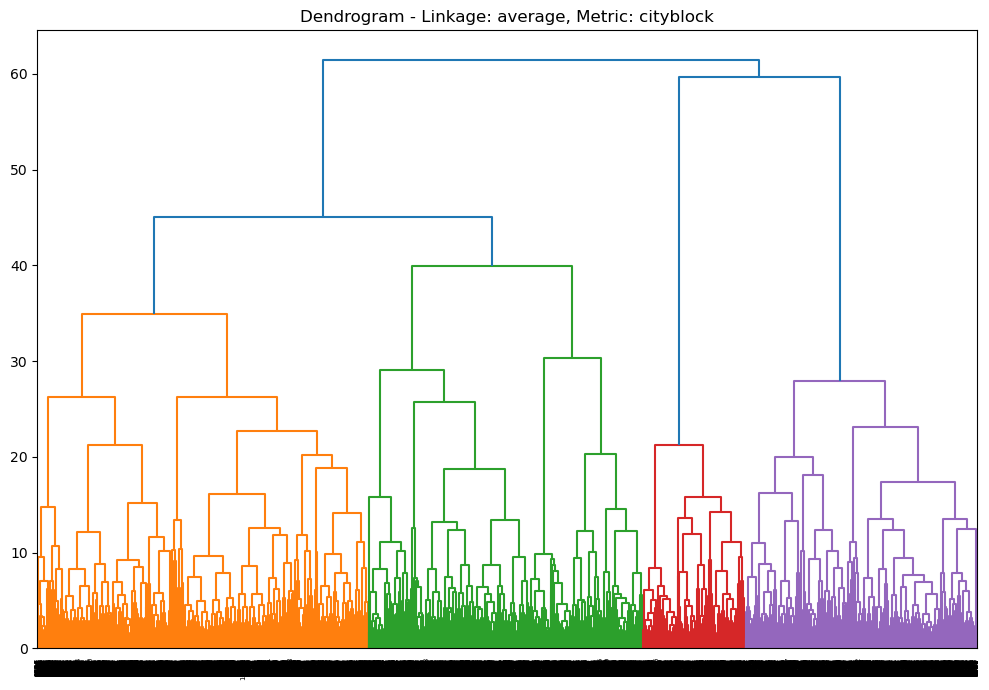

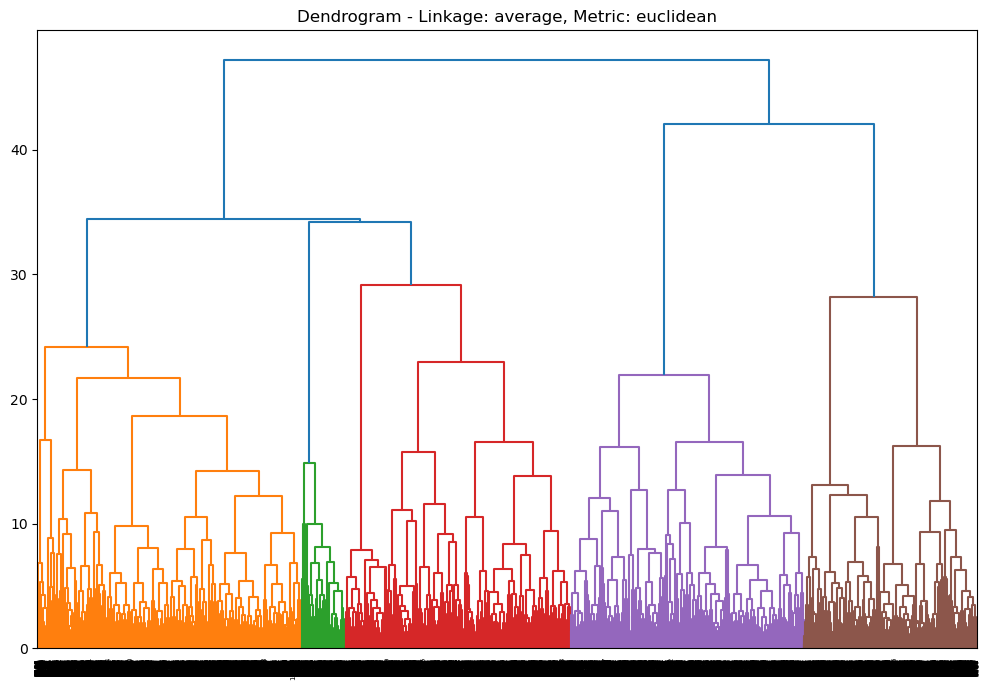

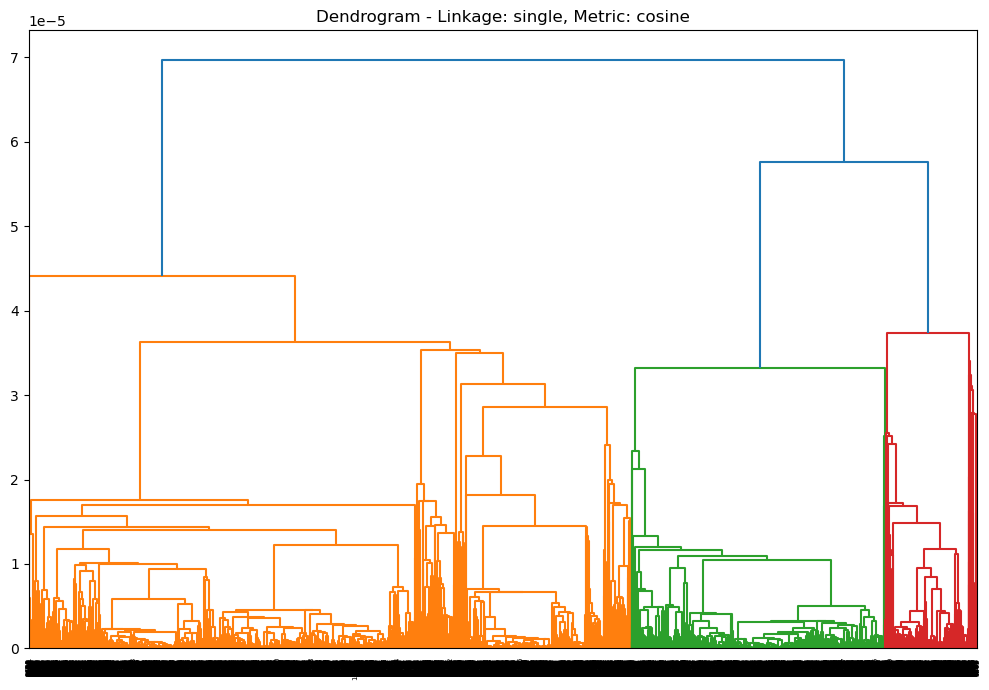

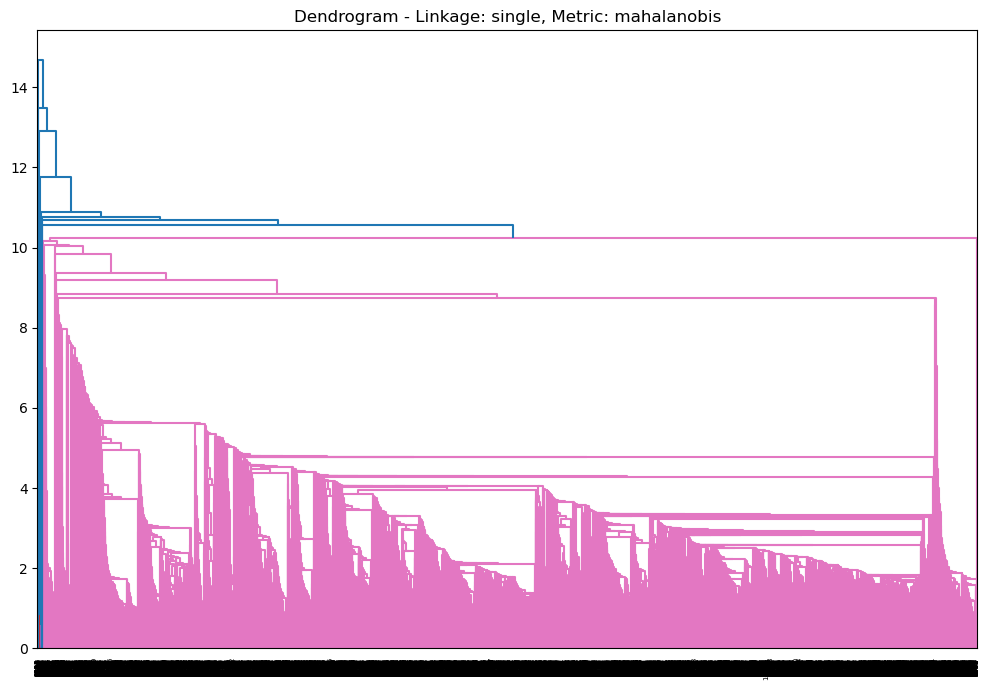

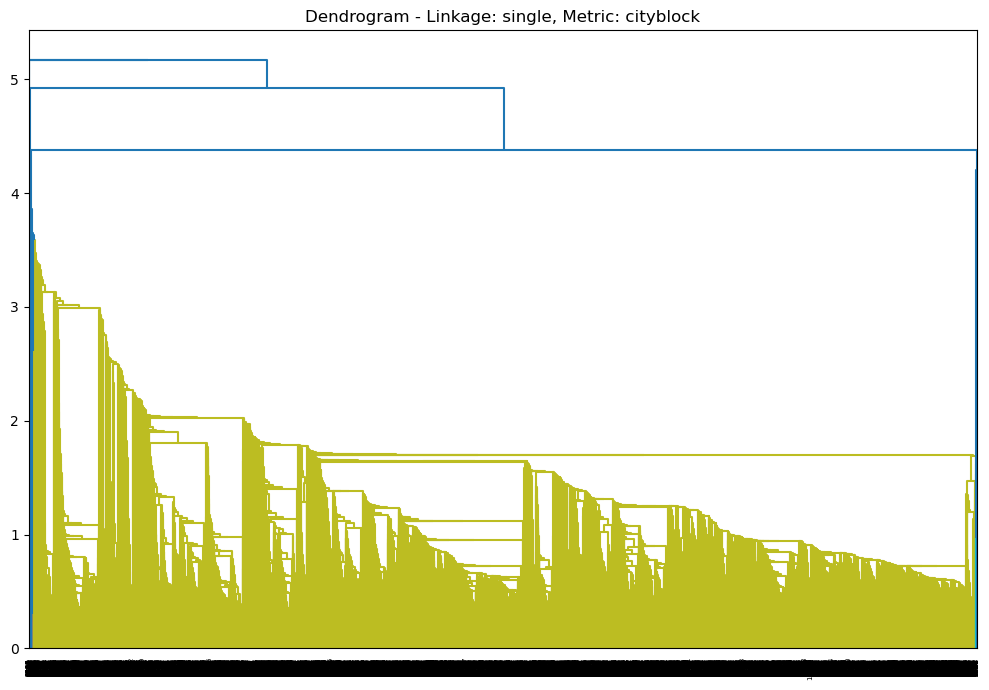

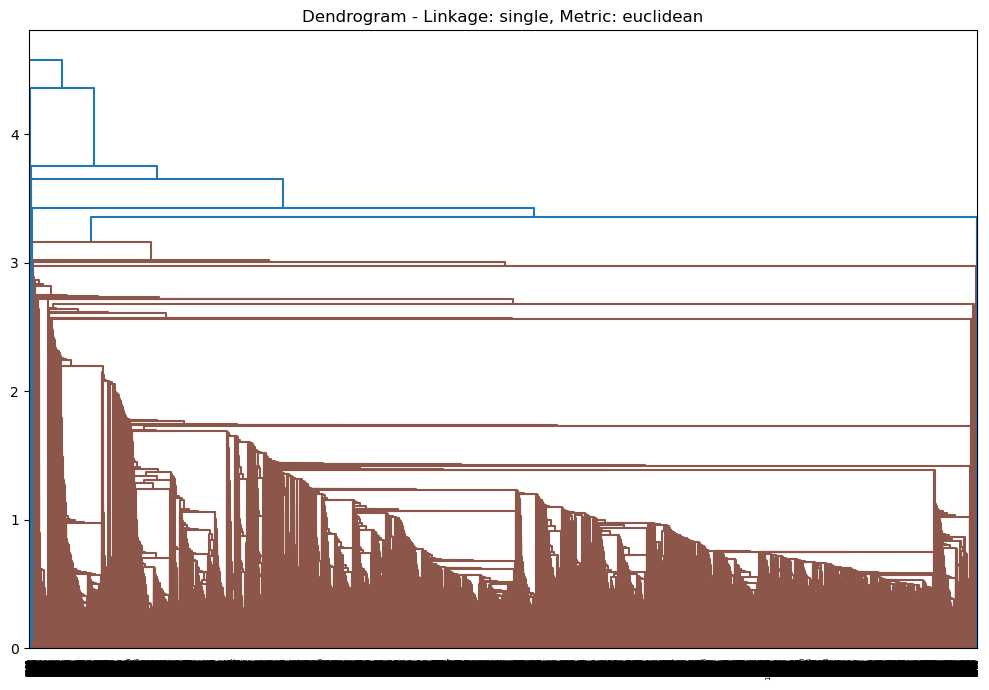

In [ ]:
# Use dendrogram to choose K
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

linkages = ['ward', 'complete', 'average', 'single']
metrics = ['cosine', 'mahalanobis', 'cityblock', 'euclidean']

for linkage_method in linkages:
    for metric in metrics:
        # Skip incompatible combinations
        if linkage_method == 'ward' and metric != 'euclidean':
            continue
        else:
            # Calculate linkage data
            # For 'mahalanobis', additional arguments are required
            if metric == 'mahalanobis':
                try:
                    # Using pdist to compute the distance matrix as mahalanobis requires VI to be invertible
                    # which might not be the case for all datasets
                    distance_matrix = pdist(df_tsne, metric=metric, VI=np.linalg.inv(np.cov(df_tsne, rowvar=False)))
                    linkage_data = linkage(squareform(distance_matrix), method=linkage_method)
                except np.linalg.LinAlgError:
                    print(f"Skipping mahalanobis for {linkage_method} due to non-invertible covariance matrix.")
                    continue
            else:
                linkage_data = linkage(df_tsne, method=linkage_method, metric=metric)

            # Plot dendrogram
            plt.figure(figsize=(10, 7))
            dendrogram(linkage_data)
            plt.title(f'Dendrogram - Linkage: {linkage_method}, Metric: {metric}')
            plt.tight_layout()
            plt.show()


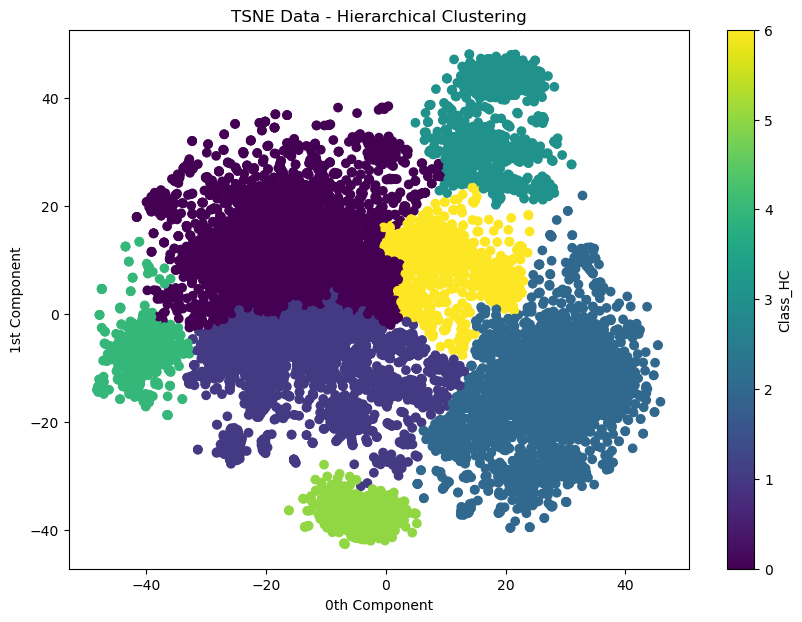

In [ ]:
# Choose K from dendrograms and run a model
hierarchical_cluster = AgglomerativeClustering(n_clusters = 7, linkage = 'average',metric='euclidean')
labels = hierarchical_cluster.fit(df_tsne)

pred_agc = pd.Series(hierarchical_cluster.labels_)
final_dataframe_CLIP_original['Class_HC'] = pred_agc
# Plot a 2D graph
x = np.array(dataframe_tsne[0]) # 0th Component
y = np.array(dataframe_tsne[1]) # 1st Component

plt.figure(figsize=(10, 7))  # Optional: Adjusts the figure size
plt.scatter(x, y, c=dataframe_tsne['Class_HC'])  # Color points by hierarchical clustering label
plt.title('TSNE Data - Hierarchical Clustering')  # Sets the title of the plot
plt.xlabel('0th Component')  # Sets the label for the x-axis
plt.ylabel('1st Component')  # Sets the label for the y-axis
plt.colorbar(label='Class_HC')  # Optional: Adds a colorbar to interpret cluster labels
plt.show()

In [ ]:
# Evaluation
silhouette_avg_TSNE_Hier = silhouette_score(dataframe_tsne.drop(columns = ['Class','Class_HC']), dataframe_tsne['Class_HC'])
print(f'silhouette_score_TSNE_Hier: {silhouette_avg_TSNE_Hier}')
dbi_TSNE_Hier = davies_bouldin_score(dataframe_tsne.drop(columns = ['Class','Class_HC']), dataframe_tsne['Class_HC'])
print(f'Davies-Bouldin Index TSNE_Hier: {dbi_TSNE_Hier}')


silhouette_score_TSNE_Hier: 0.3343462646007538
Davies-Bouldin Index TSNE_Hier: 0.7514161057220408


In [ ]:
print(f'silhouette_score_PCA_KMEANS: {silhouette_avg_PCA_KMEANS}')
print(f'Davies-Bouldin Index PCA_KEAMNS: {dbi_PCA_KMEANS}')

print(f'silhouette_score_PCA_Hier: {silhouette_avg_PCA_Hier}')
print(f'Davies-Bouldin Index PCA_Hier: {dbi_PCA_Hier}')

print(f'silhouette_score_TSNE_KMEANS_CLIP: {silhouette_avg_TSNE_KMEANS_clip}')
print(f'Davies-Bouldin Index TSNE_KEAMNS_CLIP: {dbi_TSNE_KMEANS_clip}')

print(f'silhouette_score_TSNE_Hier: {silhouette_avg_TSNE_Hier}')
print(f'Davies-Bouldin Index TSNE_Hier: {dbi_TSNE_Hier}')


silhouette_score_PCA_KMEANS: 0.2316270373287704
Davies-Bouldin Index PCA_KEAMNS: 1.5308598600091132
silhouette_score_PCA_Hier: 0.662360352537421
Davies-Bouldin Index PCA_Hier: 0.4987070102042927
silhouette_score_TSNE_KMEANS_CLIP: 0.4375605285167694
Davies-Bouldin Index TSNE_KEAMNS_CLIP: 0.7639196816156874
silhouette_score_TSNE_Hier: 0.3343462646007538
Davies-Bouldin Index TSNE_Hier: 0.7514161057220408


In [ ]:
# Result
result = {
    "Metric": [
        "Silhouette Score (PCA KMeans)",
        "Davies-Bouldin Index (PCA KMeans)",
        "Silhouette Score (PCA Hierarchical)",
        "Davies-Bouldin Index (PCA Hierarchical)",
        "Silhouette Score (t-SNE KMeans, CLIP)",
        "Davies-Bouldin Index (t-SNE KMeans, CLIP)",
        "Silhouette Score (t-SNE Hierarchical, CLIP)",
        "Davies-Bouldin Index (t-SNE Hierarchical, CLIP)"
    ],
    "Value": [
        0.2316270373287704,
        1.5308598600091132,
        0.662360352537421,
        0.4987070102042927,
        0.4375605285167694,
        0.7639196816156874,
        0.3343462646007538,
        0.7514161057220408
    ]
}

# Creating DataFrame
result = pd.DataFrame(result)
result


Metric     Value
0                    Silhouette Score (PCA KMeans)  0.231627
1                Davies-Bouldin Index (PCA KMeans)  1.530860
2              Silhouette Score (PCA Hierarchical)  0.662360
3          Davies-Bouldin Index (PCA Hierarchical)  0.498707
4            Silhouette Score (t-SNE KMeans, CLIP)  0.437561
5        Davies-Bouldin Index (t-SNE KMeans, CLIP)  0.763920
6      Silhouette Score (t-SNE Hierarchical, CLIP)  0.334346
7  Davies-Bouldin Index (t-SNE Hierarchical, CLIP)  0.751416

# Results

## Compare Silhouette Score and Davies-Bouldin Index

In [ ]:
print(f'silhouette_score_PCA_KMEANS: {silhouette_avg_PCA_KMEANS}')
print(f'Davies-Bouldin Index PCA_KEAMNS: {dbi_PCA_KMEANS}')

print(f'silhouette_score_PCA_Hier: {silhouette_avg_PCA_Hier}')
print(f'Davies-Bouldin Index PCA_Hier: {dbi_PCA_Hier}')

print(f'silhouette_score_TSNE_KMEANS_CLIP: {silhouette_avg_TSNE_KMEANS_clip}')
print(f'Davies-Bouldin Index TSNE_KEAMNS_CLIP: {dbi_TSNE_KMEANS_clip}')

print(f'silhouette_score_TSNE_Hier: {silhouette_avg_TSNE_Hier}')
print(f'Davies-Bouldin Index TSNE_Hier: {dbi_TSNE_Hier}')


silhouette_score_PCA_KMEANS: 0.2316270373287704
Davies-Bouldin Index PCA_KEAMNS: 1.5308598600091132
silhouette_score_PCA_Hier: 0.662360352537421
Davies-Bouldin Index PCA_Hier: 0.4987070102042927
silhouette_score_TSNE_KMEANS_CLIP: 0.4375605285167694
Davies-Bouldin Index TSNE_KEAMNS_CLIP: 0.7639196816156874
silhouette_score_TSNE_Hier: 0.3343462646007538
Davies-Bouldin Index TSNE_Hier: 0.7514161057220408


In [ ]:
# Result
result = {
    "Metric": [
        "Silhouette Score (PCA KMeans)",
        "Davies-Bouldin Index (PCA KMeans)",
        "Silhouette Score (PCA Hierarchical)",
        "Davies-Bouldin Index (PCA Hierarchical)",
        "Silhouette Score (t-SNE KMeans, CLIP)",
        "Davies-Bouldin Index (t-SNE KMeans, CLIP)",
        "Silhouette Score (t-SNE Hierarchical, CLIP)",
        "Davies-Bouldin Index (t-SNE Hierarchical, CLIP)"
    ],
    "Value": [
        0.2316270373287704,
        1.5308598600091132,
        0.662360352537421,
        0.4987070102042927,
        0.4375605285167694,
        0.7639196816156874,
        0.3343462646007538,
        0.7514161057220408
    ]
}

# Creating DataFrame
result = pd.DataFrame(result)
result


Metric     Value
0                    Silhouette Score (PCA KMeans)  0.231627
1                Davies-Bouldin Index (PCA KMeans)  1.530860
2              Silhouette Score (PCA Hierarchical)  0.662360
3          Davies-Bouldin Index (PCA Hierarchical)  0.498707
4            Silhouette Score (t-SNE KMeans, CLIP)  0.437561
5        Davies-Bouldin Index (t-SNE KMeans, CLIP)  0.763920
6      Silhouette Score (t-SNE Hierarchical, CLIP)  0.334346
7  Davies-Bouldin Index (t-SNE Hierarchical, CLIP)  0.751416

### Baed on the results comparison, we will choose the best model "Hierarchical Clustering Model under PCA and without CLIP"

In [ ]:
output['Class_HC'].value_counts()

0    9942
2      55
1       4
Name: Class_HC, dtype: int64

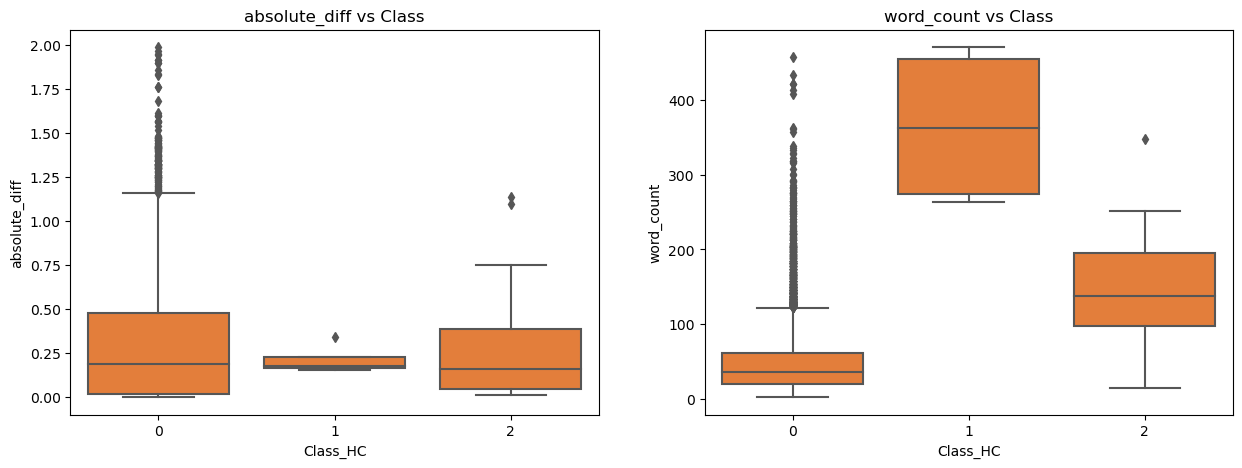

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class_HC', y = 'absolute_diff', data  = output, color = '#FF781F');
plt.title('absolute_diff vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class_HC', y = 'word_count', data  = output, color = '#FF781F');
plt.title('word_count vs Class')

plt.show()

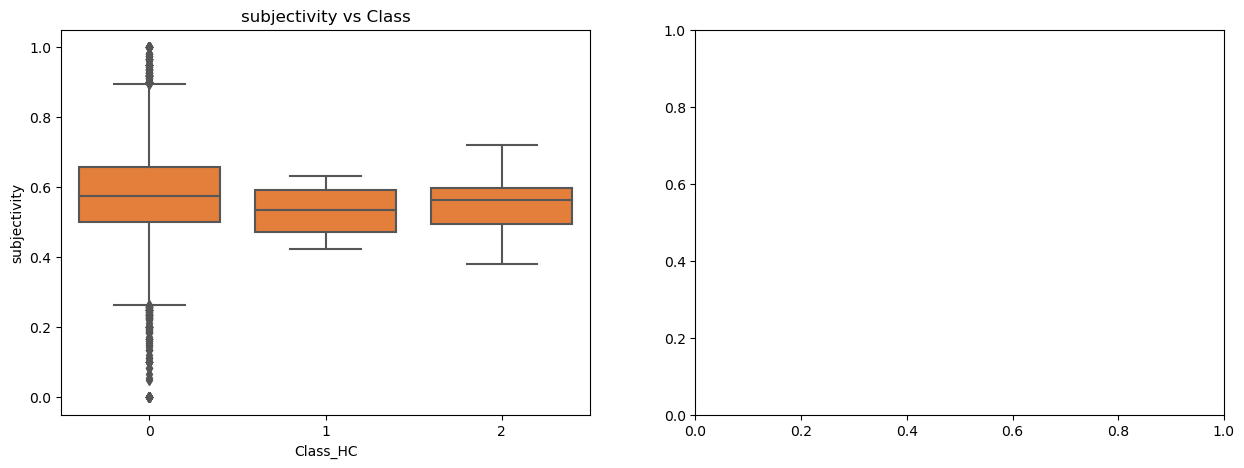

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class_HC', y = 'subjectivity', data  = output, color = '#FF781F');
plt.title('subjectivity vs Class')

plt.show()

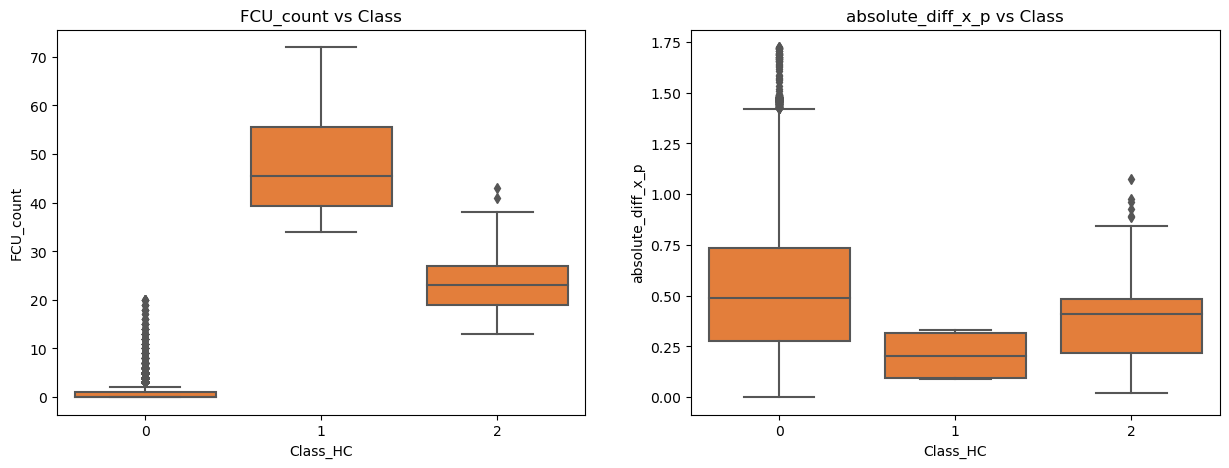

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class_HC', y = 'FCU_count', data  = output, color = '#FF781F');
plt.title('FCU_count vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class_HC', y = 'absolute_diff_x_p', data  = output, color = '#FF781F');
plt.title('absolute_diff_x_p vs Class')

plt.show()

#### According to the literature review, fake review tends to have shorter text length (word counts in our case), tend to have extreme score (more subjective/absoluate_diff_x_p), have fewer friends/reviews (in other words, less people agree to their review,  we use FunnyCoolUseful count in our case). Based on these criteria, we can conclude that group 1 will be the most useful comments and group 2 is valid but maybe not that useful and group 0 is suspicious as outliers or not useful comments since it has the shortest text length, the largest absolute difference xp, and fewest FCU counts.


### Also provide statistical plots "KMeans under Original data + CLIP + TSNE"

In [ ]:
final_dataframe_CLIP_original['Class'].value_counts()

2    4200
0    3567
1    2234
Name: Class, dtype: int64

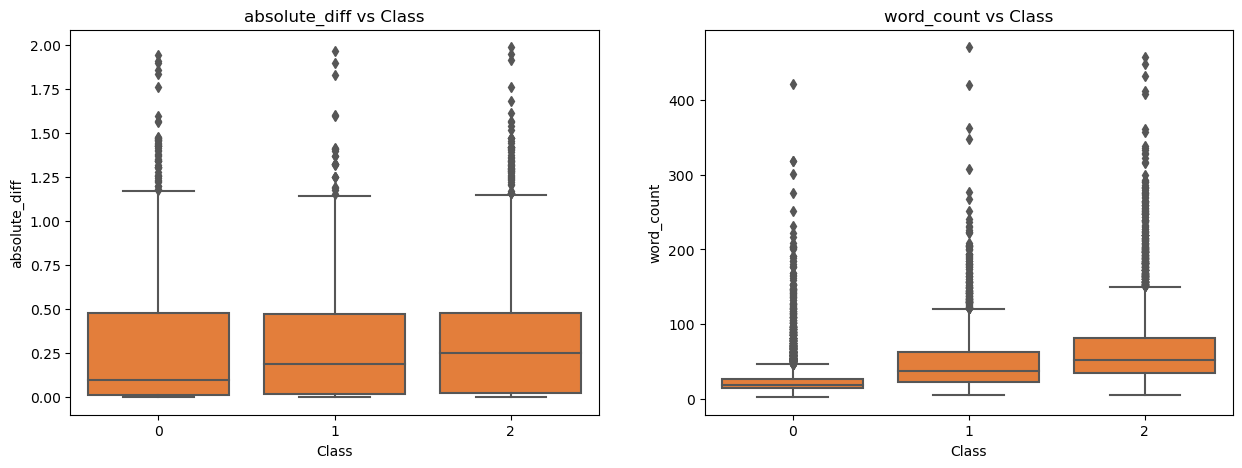

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'absolute_diff', data  = final_dataframe_CLIP_original, color = '#FF781F');
plt.title('absolute_diff vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'word_count', data  = final_dataframe_CLIP_original, color = '#FF781F');
plt.title('word_count vs Class')

plt.show()

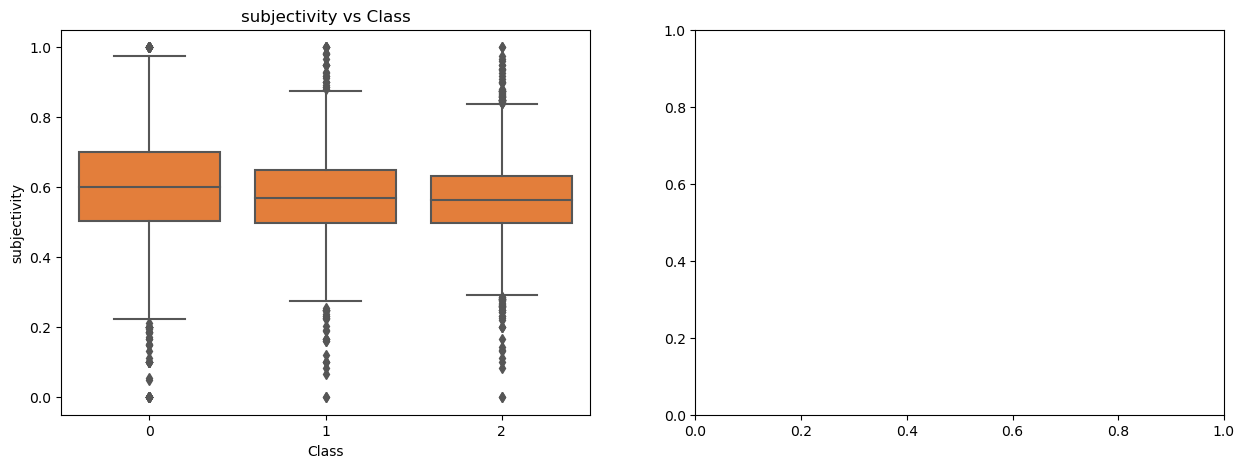

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'subjectivity', data  = final_dataframe_CLIP_original, color = '#FF781F');
plt.title('subjectivity vs Class')

plt.show()

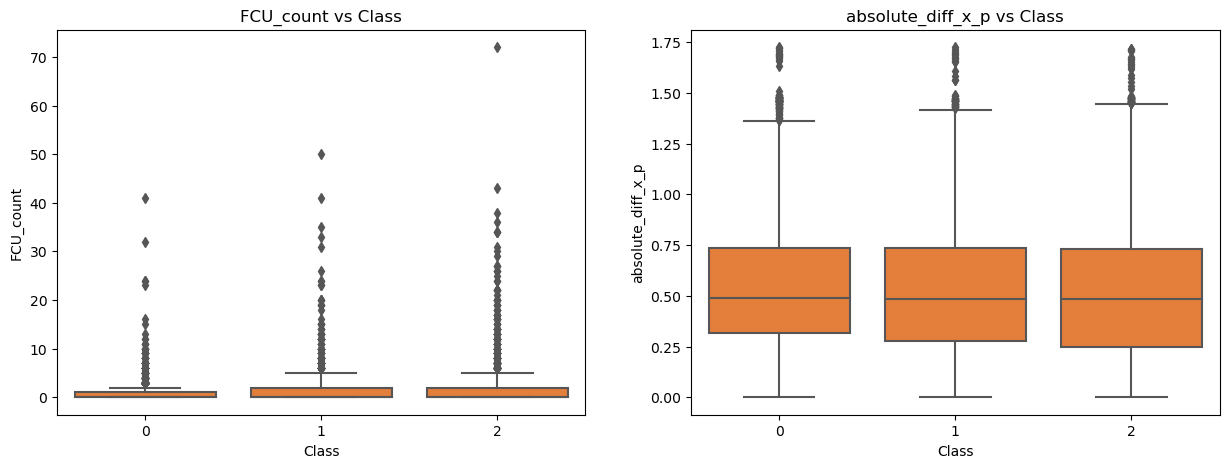

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'FCU_count', data  = final_dataframe_CLIP_original, color = '#FF781F');
plt.title('FCU_count vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'absolute_diff_x_p', data  = final_dataframe_CLIP_original, color = '#FF781F');
plt.title('absolute_diff_x_p vs Class')

plt.show()

# Literature Review

### 1. Luca, M., & Zervas, G. (2016). Fake It Till You Make It: Reputation, Competition, and Yelp Review Fraud. Management Science, 62(12), 3412-3427. https://doi.org/10.1287/mnsc.2015.2304;
### 2. Richards, J., Dabhi, S., Poursardar, F., & Jayarathna, S. (2023). Poster: Leveraging Data Analysis and Machine Learning to Authenticate Yelp Reviews. ACM, New York, NY, USA. https://doi.org/10.1145/3565287.3617983
### 3. Li, Y., Feng, X., & Zhang, S. (2016). Detecting Fake Reviews Utilizing Semantic and Emotion Model. In 2016 3rd International Conference on Information Science and Control Engineering (ICISCE). IEEE. https://doi.org/10.1109/ICISCE.2016.77
### 4. Kossakov, M., Mukasheva, A., Balbayev, G., Seidazimov, S., Mukammejanova, D., & Sydybayeva, M. (2024). Quantitative Comparison of Machine Learning Clustering Methods for Tuberculosis Data Analysis. Engineering Proceedings, 60(20). https://doi.org/10.3390/engproc2024060020